# <center>Humor as a Mirror: The New Yorker Captions as Reflections of Society, Politics, and Stereotypes</center>

<br/><br/>
<center>
    <img src="data/newyorker_caption_contest_virgin/images/666.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>

---

# <center>Milestone 3 : Table of content</center>

0. **Imports, initialisations**

1. **Recall of certain methods from Milestone 2**
   - 1.1. Data preprocessing
   - 1.2. Construction of a new funny metric
   - 1.3. Gathering of other datasets
   - 1.4. Tokenisation and lemmatisation of data
   - 1.5. Descriptive statistic tasks
   - 1.6. Building usefull metrics


2. **Narrative Flow**
   - 2.1. **Axis 1 – What Is Considered Funny**\
         - 2.1.1 : Study of what makes captions funny\
         - 2.1.2 : Are some topics inherently funnier than others and do they increase your chances of winning ?

   - 2.2. **Axis 2 – How professions are laughed about**\
         - 2.2.1 : Where do occupations appear and how frequent are they ?\
         - 2.2.2 : Are some categories of occupation funnier than others ?\
         - 2.2.3 : Do we appreciate work of other people ? Temporal & topic analysis

   - 2.3. **Axis 3 – Gender Roles and stereotypes**
         - 2.3.1 : Detect gender\
         - 2.3.2 : General Distributions\
         - 2.3.3 : Gender depiction\
         - 2.3.4 : Gender funniness

## 0. Imports, initialisations

In case an import cannot be imported run this:

In [1]:
import importlib
import src.utils.paths as p
importlib.reload(p)

<module 'src.utils.paths' from 'c:\\Users\\andra\\OneDrive\\Desktop\\MA1_2025-2026\\Applied_data_analysis\\project\\ada-2025-project-adacore42\\src\\utils\\paths.py'>

Getting the project root directory path.

In [2]:
from pathlib import Path
import sys
import os

try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH, TFIDF_MATRIX_NPZ_PATH, TF_IDF_MATRIX_METADATA_NPZ_PATH, TFIDF_MATRIX_JOBLIB_PATH, OCCUPATIONS_ANALYSIS_PKL_PATH, OCCUPATIONS_CATEGORY_ANALYSIS_PKL_PATH
print(DATA_PREPARATION_PY_PATH.resolve()) #If works: ...../ADAcore42/src/data/DataPreparation.py

Root folder detected at: c:\Users\andra\OneDrive\Desktop\MA1_2025-2026\Applied_data_analysis\project\ada-2025-project-adacore42
C:\Users\andra\OneDrive\Desktop\MA1_2025-2026\Applied_data_analysis\project\ada-2025-project-adacore42\src\data\DataPreparation.py


In [3]:
# Core
import ast
import pickle
import numpy as np
import pandas as pd
import joblib
from scipy.sparse import load_npz

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Utils
from src.utils.general_utils import *
import src.scripts.descriptive_stats_tasks as dst

# Data processing
#import src.data.tokenise as tokenise
#from src.data.tokenise import apply_preprocessing, load_data, preprocess_text_list, save_data

# 1. Recall of certain methods from Milestone 2

##### See the results from Milestone 2 [here](results_MS2.ipynb)

### 1.1. Data preprocessing
Cleaning and preprocessing of the dataset : [*The main preprocessing is done by this file*](src/data/DataPreparation.py)


### 1.2. Construction of a New Funny Metric
To better identify which captions are truly funny, we designed a new *funny metric* that combines both the **proportion of votes** and the **popularity (number of votes)** of each caption.

*écrire la démarche de la nouvelle metric ?*


### 1.3. Gathering of other datasets
**Temporal dataset augmentation** : The following webpage has dates of some of the contests. We add it to the **dataC** table as a new column:
"https://nextml.github.io/caption-contest-data/"


**Occupations dataset :** Five datasets of varying size and specificity were loaded. In total, these add up to around 33,000 occupations.
 - [**O*NET**](https://www.onetonline.org/find/all)  
 - [**ESCO (ESCO dataset v1.2.0)**](https://esco.ec.europa.eu/en/use-esco/download)   
 - [**Kaggle Job Description Dataset**](https://www.kaggle.com/datasets/ravindrasinghrana/job-description-dataset)  
 - [**US Labor Statistics (May 2024, all data)** ](https://www.bls.gov/oes/tables.htm)   
 - [**US Census Data (2018 Census Occupation Index)**](https://www.census.gov/topics/employment/industry-occupation/guidance/indexes.html)

This code is not included in the results. This is because it requires conflicting package versions. The code can be seen [here](src\scripts\occupations.ipynb), but it should not be run as the files it is reading from do not exist in the given folder. In any case, it does not have output, and the prouced file is available to all in the data folder.

**Gender dataset :** *Dictionary of gendered words*: This dictionary was constructed based on Danielle Sucher's "Jailbreak the Patriarchy" (https://github.com/DanielleSucher/Jailbreak-the-Patriarchy)

### Executing the DataPreparation.ipynb file

This cell executes all what's been described in section 1.1. We did not want to copy paste the code here to keep this result file clean, but for any verification about the code, please refer to ```src\data\DataPreparation.py```.


In [ ]:
#%run {DATA_PREPARATION_PY_PATH.resolve()}

In [4]:
# Pickle datapreprocessed file loading
with open(STORED_DATAPREP_PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Objects extraction
dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

### 1.4. Tokenisation and lemmatisation of data

*.......*


### 1.5. Descriptive statistic tasks

*See code and results from Milestone 2, those statistics were used to build our methods for milestone 3 (skewed distribution of votes and mean funny_score, most cited locations in the cartoons, types of questions W-words...)*

[Cartoon 620] KS-stat=0.1114, p-value=0.000000
[Cartoon 662] KS-stat=0.0781, p-value=0.000000
[Cartoon 772] KS-stat=0.1091, p-value=0.000000
[Cartoon 882] KS-stat=0.1041, p-value=0.000000


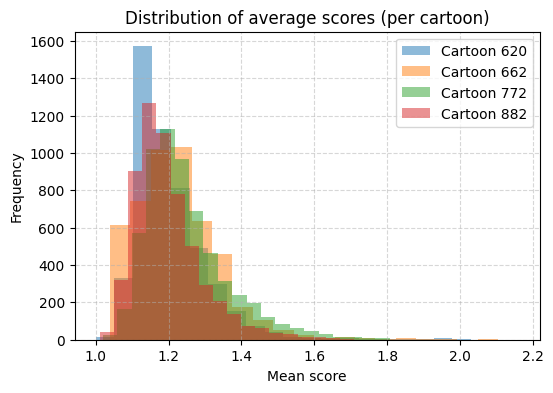

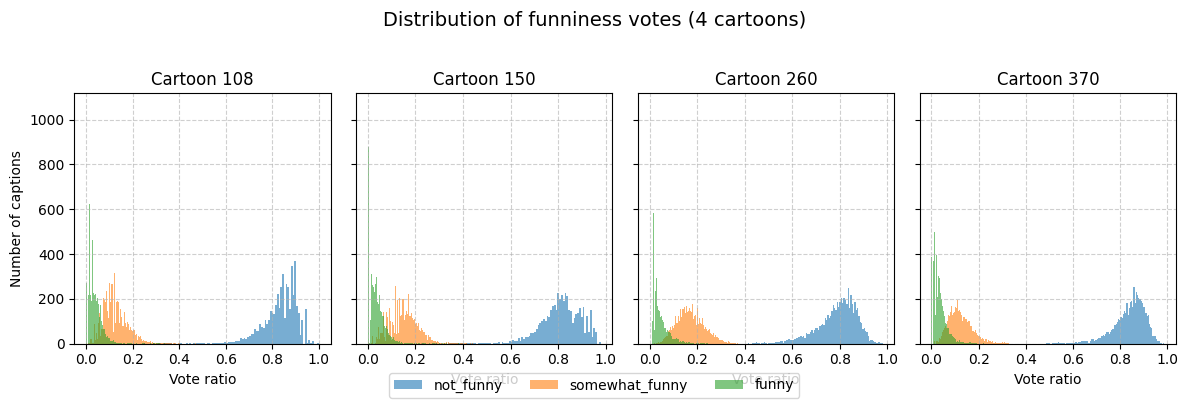

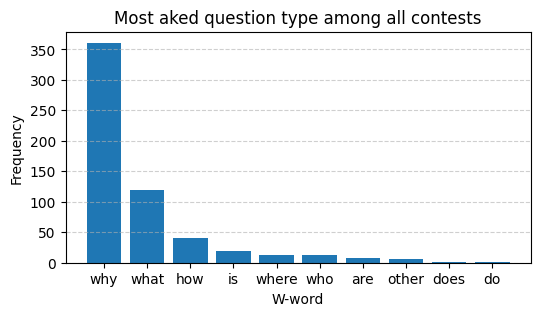

In [143]:
# histogram : avg score of all captions proposed + Kolmogorov–Smirnov test : normal distribution
histo = dst.plot_mean_histograms(dataA, boxplot=False)
# histogram : 'not_funny'/'somewhat_funny'/'funny' ratios among all captions, for the cartoon
dst.plot_funny_ratios(dataA)

### Plots/stats on all cartoons (dataC)
all_questions = [quest for sublist in dataC["questions"].dropna() for quest in sublist]
# 2.3.4: Top10 most used question's W-words
most_asked_question = dst.plot_question_types(all_questions)

### 1.6. Building usefull metrics

In [1]:
#from src.models.similarity_analysis import CaptionClustering, SimilarHumorAnalysis, SimilarityModel

***To access to the definitions and content of classes SimilarityModel,***\
***CaptionClustering, SimilarHumorAnalysis, please see : [here](src\models\similarity_analysis.py)***

# 2. Narrative Flow

## 2.1. Axis 1 – What Is Considered Funny

### 2.1.1 : Study of what makes captions funny
##### a. Data preparation
The data were aggregated to create a large dataset containing all captions. To keep track of which dataset each caption comes from, we added a source_id column. We then used TextBlob to extract textual features from the captions, such as word count, punctuation count, repetitions, polarity, and subjectivity.

Since this processing step is time-consuming and involves a large dataset, we chose not to load it directly in this notebook. Instead, we include the code in comment and the figures that were generated and saved beforehand in order to reduce the size of the Jupyter notebook. All of this analysis was carried out in the notebook P3_what_is_funny, located in the katia_analysis folder.

In [11]:
"""
dataA = data['dataA']

dfs_with_id = [
    df.assign(source_id=i)   # add columns with ID of original dataset 
    for i, df in enumerate(dataA)
]
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)
dataAm2.sort_values(by='funny_score_scaled', ascending=False, inplace=True)
dataAm2_2=dataAm2.drop_duplicates() # necessary because some captions were duplicated on some dataframes 
results_blob = []

dataAm2_2 = dataAm2_2.reset_index().rename(columns={"index": "caption_id"})
for i, cap in tqdm(zip(dataAm2_2['caption_id'], dataAm2_2['caption']), total=len(dataAm2_2)):
    blob = TextBlob(cap)
    results_blob.append({
        'caption_id': i,
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'num_words': len(blob.words),
        'num_punct': len(re.findall(r'[^\w\s]', cap)),
        'num_repeats': len(re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
    })

df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2_2.merge(df_blob, on="caption_id", how="inner")
dataAm_rf= dataAm_rf[dataAm_rf["num_words"]<80] # remove captions that were badly encoded
"""

<>:21: SyntaxWarning: invalid escape sequence '\w'
<>:21: SyntaxWarning: invalid escape sequence '\w'
/var/folders/0d/kr1pn92d0bd9d8ny0zc6hpdc0000gn/T/ipykernel_64305/1998408718.py:21: SyntaxWarning: invalid escape sequence '\w'
  'num_punct': len(re.findall(r'[^\w\s]', cap)),


'\ndataA = data[\'dataA\']\n\ndfs_with_id = [\n    df.assign(source_id=i)   # add columns with ID of original dataset \n    for i, df in enumerate(dataA)\n]\ndataAm2 = pd.concat(dfs_with_id, ignore_index=True)\ndataAm2.sort_values(by=\'funny_score_scaled\', ascending=False, inplace=True)\ndataAm2_2=dataAm2.drop_duplicates() #\xa0necessary because some captions were duplicated on some dataframes \nresults_blob = []\n\ndataAm2_2 = dataAm2_2.reset_index().rename(columns={"index": "caption_id"})\nfor i, cap in tqdm(zip(dataAm2_2[\'caption_id\'], dataAm2_2[\'caption\']), total=len(dataAm2_2)):\n    blob = TextBlob(cap)\n    results_blob.append({\n        \'caption_id\': i,\n        \'polarity\': blob.sentiment.polarity,\n        \'subjectivity\': blob.sentiment.subjectivity,\n        \'num_words\': len(blob.words),\n        \'num_punct\': len(re.findall(r\'[^\\w\\s]\', cap)),\n        \'num_repeats\': len(re.findall(r\'\x08(\\w+)\\s+\x01\x08\', cap.lower()))\n    })\n\ndf_blob = pd.DataFram

##### b. Data exploration and results
We first examined the distribution of the funny score across our dataset. The following plot, together with the results of the Anderson test, shows that the distribution is not normal. It is skewed on both sides, with a stronger skew for larger values.

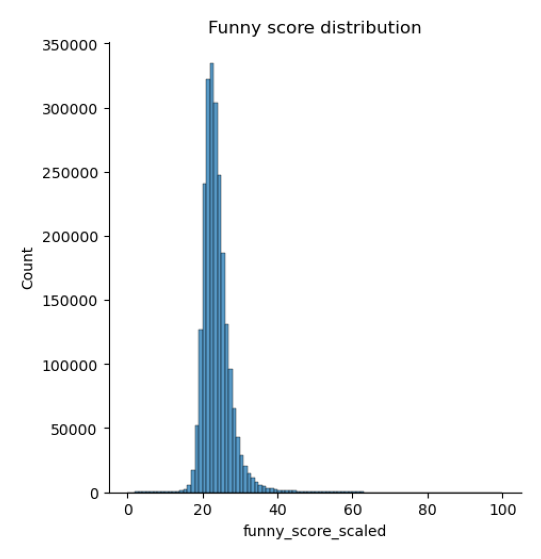

AndersonResult(statistic=np.float64(50595.25888574589), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(23.740472574965178), scale=np.float64(3.7631580153665776))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [8]:
path_fig = "_Other/katia_analysis/plot_result/"
img = plt.imread(f"{path_fig}distribution_funny_score1.1.png")

plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis("off")
plt.show()

with open(f"{path_fig}anderson_test_results.txt", "r") as f:
    loaded_anderson = f.read()

print(loaded_anderson)


We therefore decided to use quantiles to create groups of the funniest and least funny captions, as this approach does not rely on any assumption about the underlying distribution. We used extreme quantiles at 0.01% which produce group of around 230 captions each.

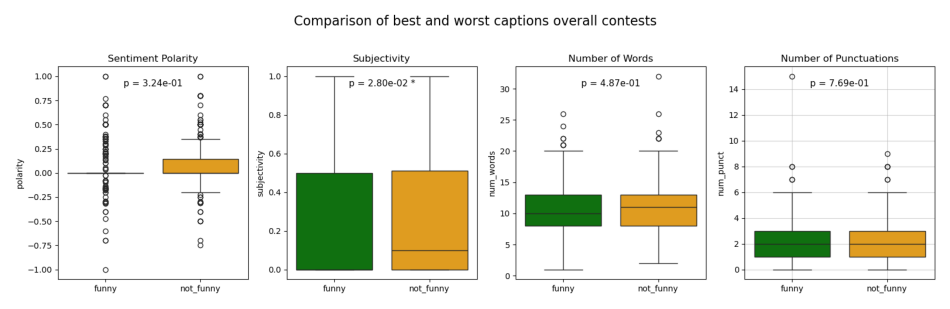

,funny_group3,total_rows,unique_caption
0,funny,231,84
1,mid_funny,2291847,384
2,not_funny,230,4


In [ ]:
"""
low_threshold = dataAm_rf["funny_score_scaled"].quantile(0.0001)
high_threshold = dataAm_rf["funny_score_scaled"].quantile(0.9999)
def assign_group(row, high_threshold, low_threshold):
    if row['funny_score_scaled'] >= high_threshold:
        return 'funny'
    elif row['funny_score_scaled'] <= low_threshold:
        return 'not_funny'
    else:
        return 'mid_funny'
dataAm_rf["funny_group3"] = dataAm_rf.apply(assign_group, axis=1, high_threshold=high_threshold, low_threshold=low_threshold)
dataAm_rf_filtered = dataAm_rf[dataAm_rf["funny_group3"] != 'mid_funny']

features = ['polarity', 'subjectivity', 'num_words', 'num_punct']
groups = ['funny', 'not_funny']
ax_one.plot_boxplot_static(
    dataAm_rf_filtered,
    columns_category="funny_group3",
    features=features,
    save_fig=False,
    title="funny_vs_not_funny"
)
"""
img1 = plt.imread("plot_result/bocplot_1.png")

plt.figure(figsize=(12,10))
plt.imshow(img1)
plt.axis("off")
plt.show()
summary_df = pd.read_csv("plot_result/unique_caption_summary.csv")
display(summary_df)

The results indicate that only subjectivity differs significantly between the groups. However, as shown in the table above, the “not funny” group consists of captions from only four contests. This imbalance may bias the results toward the specific themes or styles of these contests rather than reflecting general trends. To address this, we repeated the analysis on a different dataset containing the funniest and least funny captions from each contest, providing a more representative overview across all contests.

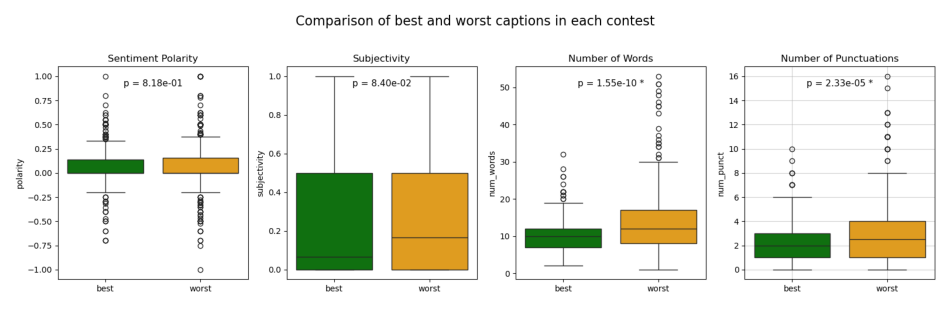

In [9]:
"""
idx_best = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmax()
idx_worst = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmin()
df_best = dataAm_rf.loc[idx_best].copy()
df_best["caption_type"] = "best"

df_worst = dataAm_rf.loc[idx_worst].copy()
df_worst["caption_type"] = "worst"
df_combined = pd.concat([df_best, df_worst], ignore_index=True)

ax_one.plot_boxplot_static(
    df_combined,
    columns_category="caption_type",
    features=features,
    save_fig=False,
    title="best_vs_worst"
)
"""
img1 = plt.imread(f"{path_fig}boxplot_2.png")

plt.figure(figsize=(12,10))
plt.imshow(img1)
plt.axis("off")
plt.show()

The results now show significant differences in both the number of words and punctuation, with funnier captions tending to be shorter.

##### c. Funny prediction

To assess fun, we also performed logistic regression on the best and worst captions for each cartoon dataset. 

First, the data were standardized, and the best and worst categories were converted into a binary format. We then used the statsmodels package to fit a logistic regression model, with the target variable being whether a caption is funny (1) or not funny (0). The predictors included same features as before : word count, punctuation, polarity, subjectivity, and repetitions.


In [ ]:
"""
df_combined.loc[:, "category"] = np.where(df_combined['caption_type'] == "best", '1', '0')

cols_to_standardize = ["num_words", "polarity", "subjectivity","num_repeats","num_punct"]
df = df_combined.copy()
for col in cols_to_standardize:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
df["category"] = df["category"].astype(int)

mod = smf.logit(formula='category ~  num_words + polarity + subjectivity + num_repeats + \
                        num_punct ', data=df)
res = mod.fit()
print(res.summary())
"""


In [10]:
with open(f"{path_fig}logit_summary.txt", "r") as f:
    loaded_summary = f.read()

print(loaded_summary)

                           Logit Regression Results                           
Dep. Variable:               category   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                 0.04416
Time:                        18:00:16   Log-Likelihood:                -508.83
converged:                       True   LL-Null:                       -532.34
Covariance Type:            nonrobust   LLR p-value:                 5.650e-09
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0238      0.075     -0.317      0.751      -0.171       0.123
num_words       -0.5159      0.109     -4.712      0.000      -0.730      -0.301
polarity        -0.0134      0.076     -0.17

The results show that the model explains only a small portion of the variance, with a pseudo R² of just 4%. Among the predictors, the number of words is the only feature with a significant p-value. Its negative coefficient indicates that longer captions tend to be perceived as less funny. This finding is consistent with our previous analysis. However, unlike before, the number of punctuation marks no longer appears to have a significant effect. The second most influential feature here is the number of repetition.

##### c.bis Prediction over larger dataset

Other models, including additional logistic regressions and a random forest, were also tested on a larger dataset (around 132996 captions in total). These models were not able to explain more of the variance, in fact, they accounted for even less. This highlights the high variability in the dataset and that it is hard to predict fun with the few simple features given here!

### 2.1.2 : Are some topics inherently funnier than others, and do they increase your chances of winning ?

We will now dive into an analysis of caption topics. To do so, we will first cluster captions according to their topics, using a BERTtopic model, analyse if some topics create more fun than others, and then examine where the winning captions stand.

To illustrate this, we will focus on a single contest, the one from May 23, 2022, featuring the cartoon below. Let’s see what we can discover!

Contest number 801, published May 23, 2022 :
<center>
    <img src="data/newyorker_caption_contest_virgin/images/801.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>


*Top Rated caption* : “What do you mean I don’t have time for another game?”\
*The New Yorker's winner* : “I thought you’d be better at the endgame.”

We first tried to find clusters of topics using Kmeans, DBSCAN, agglomerative, and spectral clustering methods, varying the number of cluster (with the hyperparameter "n_clusters") (see the benchmark that was done [*here*](_Other/cycy_analysis/cycy_results_MS3.ipynb)). But the corresponding silouhette score and [intra-cluster similarity metric](src\models\similarity_analysis.py) calculated was really not satisfying. As discussed on Milestone 2 results, this limitation has been adressed by choosing a more adapted model : the pretrained BERTtopic model.

About:
- **BERTtopic embedding** : semantic embedding model : all-MiniLM-L6-v2 (maps sentences & paragraphs to a 384 dimensional dense vector space, designed for natural language understanding of short phrases like captions),
- **UMAP dimensionality reduction** : reduce the 384 dimensional vector space, well adapted for non linear relations,
- **HDBSCAN clustering algorithm** : The number of minimum size of clusters should be determined by a test over different values, and picking the hyperparameters *'min_topic_size'* that gives the best clusterization.

In [5]:
import src.models.topic_clustering_analysis as topic_clustering

importlib.reload(topic_clustering)
from src.models.topic_clustering_analysis import CaptionTopicClusterer

CONTEST_IDX = 289

c:\Users\cyrie\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### a. Finding the good minimum number of elements per topics:

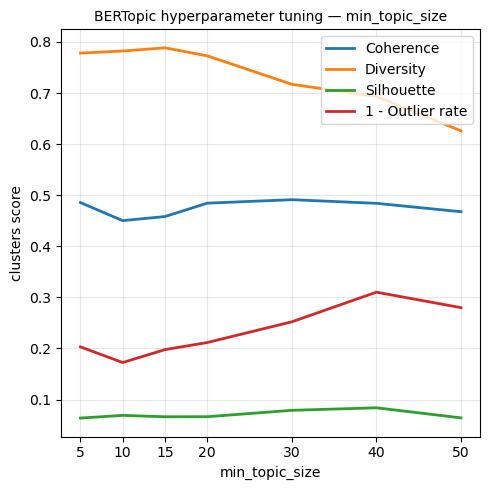

In [ ]:
contest_idx = CONTEST_IDX
df_eval_test = pd.read_csv(os.path.join("_Other", "cycy_analysis", "saved_289", f"df_eval_test_contest_{contest_idx}.csv"))

x = df_eval_test["min_topic_size"]

plt.figure(figsize=(5,5))
plt.plot(x, df_eval_test["coherence"].values, linewidth=2, label="Coherence")
plt.plot(x, df_eval_test["diversity"].values, linewidth=2, label="Diversity")
plt.plot(x, df_eval_test["silhouette"].values, linewidth=2, label="Silhouette")
plt.plot(x, df_eval_test["outlier_rate"].values, linewidth=2, label="1 - Outlier rate")
plt.title("BERTopic hyperparameter tuning — min_topic_size", fontsize=10)
plt.xlabel("min_topic_size")
plt.ylabel("clusters score")
plt.xticks(x)
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The best min_topic_size is the one just before the drop in coherence and the massive increase in outliers. This does not appear here, so the best balance seems to be for *min_topic_size* = 30. We can do the actual topic clustering with this value.

Remark : For humorous captions, embeddings are highly dispersed, with many near-singletons : this naturally leads to a low silhouette score. Human inspection of results was also done to best choose this value than to the silhouette metric.

##### b. Identify common topics among all captions


In [6]:
contest_idx = CONTEST_IDX
data_m = dataA[contest_idx].copy()
captions = data_m["caption"].tolist()

clusterer = CaptionTopicClusterer(fun_metric="funny_score_scaled", min_topic_size=30, verbose=False)  #can also use as fun_metric : funny_score_scaled

# Clusterize topics (do it only once, then save the results)
"""fit_topic = clusterer.fit_transform(captions)

with open(f"fit_topic_mints=30_contest_{contest_idx}.pkl", "wb") as f:
    pickle.dump(
        {
            "contest_idx": contest_idx,
            "min_topic_sizes": 30,
            "fit_topic": fit_topic
        }, f)

df_topic_info = fit_topic["df_topic_info"]
#df_topics.to_csv(os.path.join("_Other", "cycy_analysis", f"caption_labeled_topics_{contest_idx}.csv"), index=False)
df_topic_info.to_csv(os.path.join(f"info_topics_{contest_idx}.csv"), index=False)"""



with open(os.path.join("_Other", "cycy_analysis", "saved_289", f"fit_topic_mints=30_contest_{contest_idx}.pkl"), "rb") as f:
    data = pickle.load(f)

fit_res = data["fit_topic"]
data_m["topic_nb"] = fit_res["topics"]
df_topic_info = fit_res["df_topic_info"]

# Aggregate clusters into less topics
agg_info = clusterer.compute_aggregated_topic_info(df_topic_info, clusterer.agg_topic_289)      # agg_topic_289 TO CHANGE IF AN OTHER CONTEST !!!

# Calcule mean score of all captions by aggregated topic
df_scores = clusterer.compute_topic_scores(data_m, clusterer.agg_topic_289)                     # agg_topic_289 TO CHANGE IF AN OTHER CONTEST !!!

##### c. Comparing funny score of all topics

The following graph shows distribution of standardized humor scores for each topic identified in the cartoon of May 23, 2022. Each theme is represented in a sub-graph, with two elements:
- **Histogram**: illustrates the relative frequency of scores.
- **KDE (Kernel Density Estimation) curve**: indicates the relative probability that a score will take a certain value. The higher the curve, the more likely it is that the scores will fall within that range. KDE allows us to see the overall shape of the distribution, regardless of the exact number of measurements.


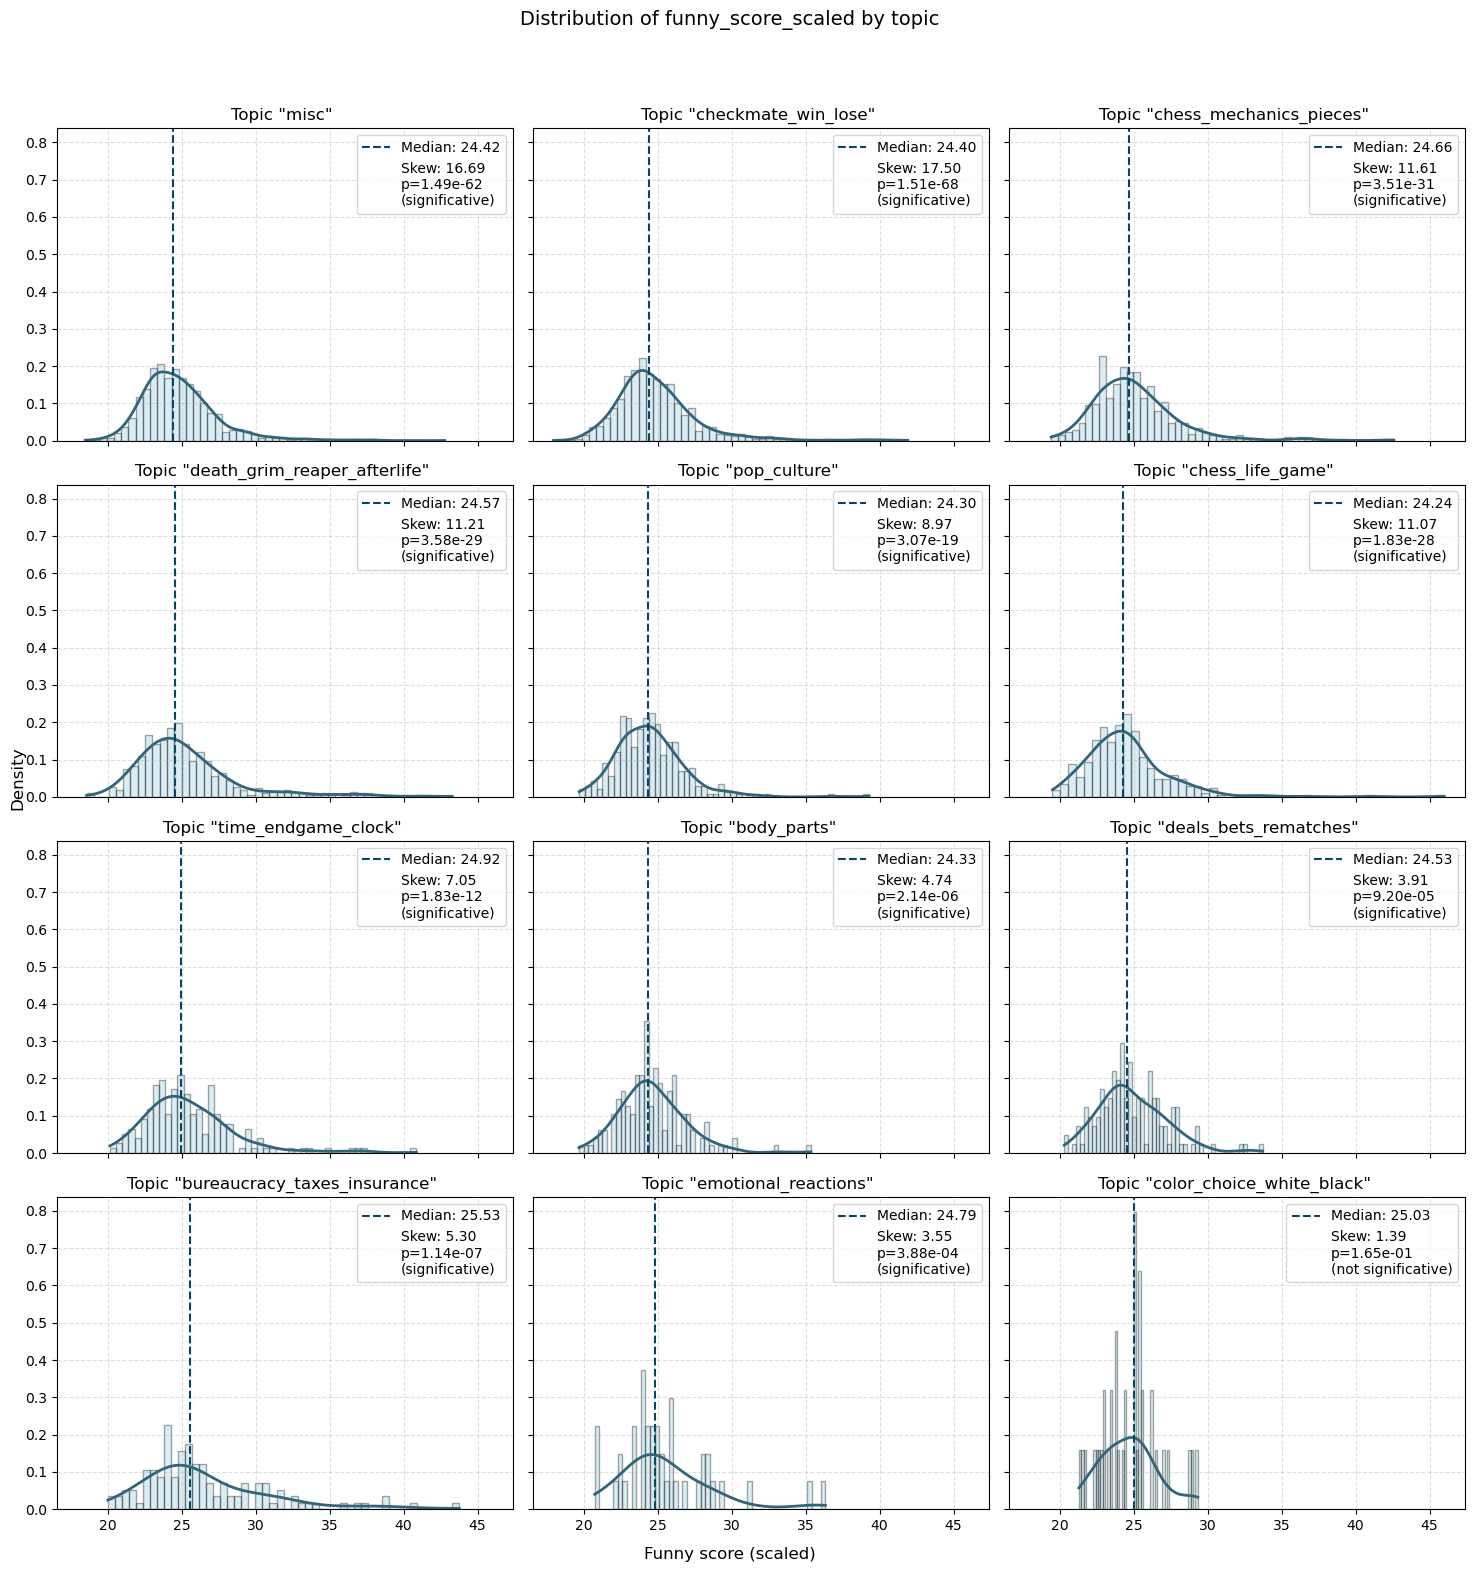

Kruskal-Wallis test (H, p): 50.71, pval = 4.6586e-07


In [7]:
# compare distributions with kde
clusterer.plot_funny_score_distributions_by_topic_subplots(data_m, top_n_topics=12) #, save=os.path.join("_webappp", "assets", "graph", f"distribution_funnyscore_kde_topics_{contest_idx}.jpg")

# calculer la variance par topic
df_var = clusterer.compute_variance_stats(data_m)
#display(df_var)

kw_res= clusterer.kruskal_test(data_m)
print(f"Kruskal-Wallis test (H, p): {kw_res["H"]:0.2f}, pval = {kw_res["p"]:0.4e}")

pairwise_res = clusterer.pairwise_mannwhitney(data_m)
#pairwise_res.to_csv(os.path.join("_Other", "cycy_analysis", "saved_289", f"test_stats_{contest_idx}.csv"))


All topic distributions observed (except for one) show significant positive asymmetry (statistically significant skewness, p < 0.05), which means that scores tend to be concentrated at lower values with awith a long right tail of very funny captions. This results in a medians relatively similar across topics, and escpecially low (around 25/100). This distribution arises from the fact that we aggregated together all topics from the cartoon, and there is a lot with low funny score values, with only a few of outstanding funny ones.

The Kruskal-Wallis test shows that there is at least one topic whose metric distribution differs from the others (p = ). We reject the null hypothesis (H0: equality of medians).

The detailed result of the pairwise test can be found in the following [csv file]("_Other\cycy_analysis\saved_289\test_stats_289.csv").

Mann–Whitney pair-wise tests with Bonferroni correction highlight eight statistically significant comparisons, indicating robust differences between certain themes. The significant comparisons are as follows:

- bureaucracy_taxes_insurance vs pop_culture (p_adj = 1.88e-5)
- bureaucracy_taxes_insurance vs chess_life_game (p_adj = 2.21e-5)
- bureaucracy_taxes_insurance vs misc (p_adj = 6.63e-04)
- bureaucracy_taxes_insurance vs checkmate_win_lose (p_adj = 9.84e-4)
- bureaucracy_taxes_insurance vs body_parts (p_adj = 8.03e-3)
- bureaucracy_taxes_insurance vs chess_mechanics_pieces (p_adj = 4.12e-2)
- pop_culture vs time_endgame_clock (p_adj = 0.003.33)
- chess_life_game vs time_endgame_clock (p_adj = 0.00366)


One topic stands out clearly: Bureaucracy, Taxes & Insurance.
This topic’s humor-score distribution differs significantly from most others. A smaller but notable effect is also observed for Time, Endgame & Clocks.


**A Synthetic View with Boxplots :** 
To summarize these distributions, we use boxplots per topic. Outliers correspond to captions that have received very high ratings.

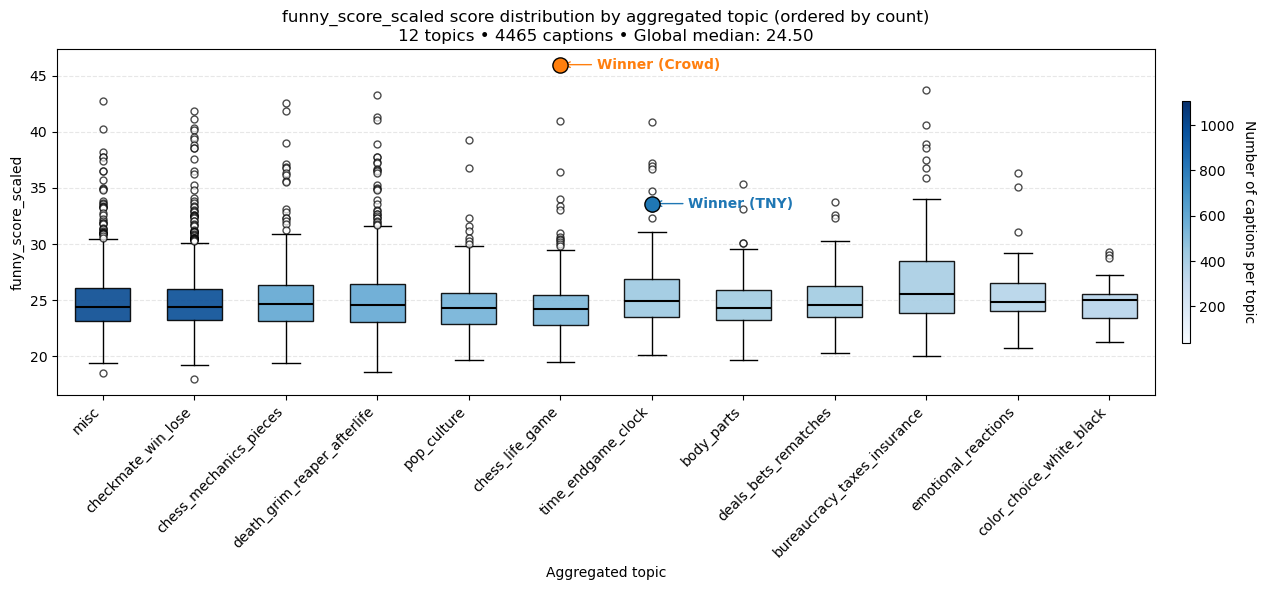

Caption TNY trouvée : True
Caption Crowd trouvée : True


In [8]:
caption_crowd="What do you mean I don’t have time for another game?"
caption_tny="I thought you'd be better at the endgame."
topic_crowd = data_m.loc[data_m["caption"] == "What do you mean I don’t have time for another game?", "aggregated_topic"].iloc[0]
topic_tny = data_m.loc[data_m["caption"] == "I thought you'd be better at the endgame.", "aggregated_topic"].iloc[0]

# Boxplot (funny score distribution within each topic)
#clusterer.plot_topic_scores2(data_m, df_scores, order_by = "count", save=os.path.join("_webappp", "assets", "graph", f"boxplot_topics_{contest_idx}.html"))
#clusterer.plot_topic_scores2_with_winners(data_m, df_scores, order_by = "count", caption_crowd=caption_crowd, caption_tny=caption_tny, save=os.path.join("_webappp", "assets", "graph", f"boxplot_topics_with_winners_{contest_idx}.html"))
clusterer.plot_topic_scores2_with_winners_plt(data_m, df_scores, order_by = "count", caption_crowd=caption_crowd, caption_tny=caption_tny, save=os.path.join("_Other", "cycy_analysis", "saved_plots", f"boxplot_topics_with_winners_plt_{contest_idx}.jpg"))

What we observe : 
- Very close medians between topics: No theme clearly dominates on average.

- Strong right-hand asymmetry for all topics: visual confirmation of the long-tail distribution already discussed.

- Very different variability depending on the topic: some have few outliers but a compact box, others (notably bureaucracy/taxes/insurance) show many very high outliers.

- Overrepresentation of certain topics, with a topic size varying from 39 to 1086 captions (excluding misc. topic) : some themes simply generate more proposals than others. There is a preponderant type of jokes done by people.

Being able to hover over outliers to read the captions is crucial: we can immediately see that the best captions are not “best on average,” but radically different.

This graph perfectly illustrates why the question “Which topic is the funniest?” is poorly phrased. The median obscures the important information: a topic's ability to produce brilliant exceptions. This box plot confirms that humorous performance is not determined by the average, but by the right tail of the distribution.


##### d. Long-tail distribution bias of humour:

We saw that humor scores follow a long-tail distribution. Indeed, if each topic clustered contains many mediocre captions and a few exellent ones, the average will flatten everything, resulting in a very low average score per topic. Therefore, we need to look beyond the average.

**So instead of asking: “Which topic is funniest on average?” we ask ourselves this question: “Which topics produce the most excellent captions?”**

We can use two differetn point of view to answer this question:

*Method 1. Isolate the top 10% and the baseline average range (40–60%). We then compute an enrichment score: How much more represented is a topic in the top captions compared to the average pool? This shows if whether certain topics are over-represented in the top rankings versus the average baseline (=top proportion vs. overall baseline proportion).*

*Method 2. Calculate the success rate (defined a score above a score threshold : 30/100 for the funny_score_scaled)*



Let's see how does that changes our topic analysis...

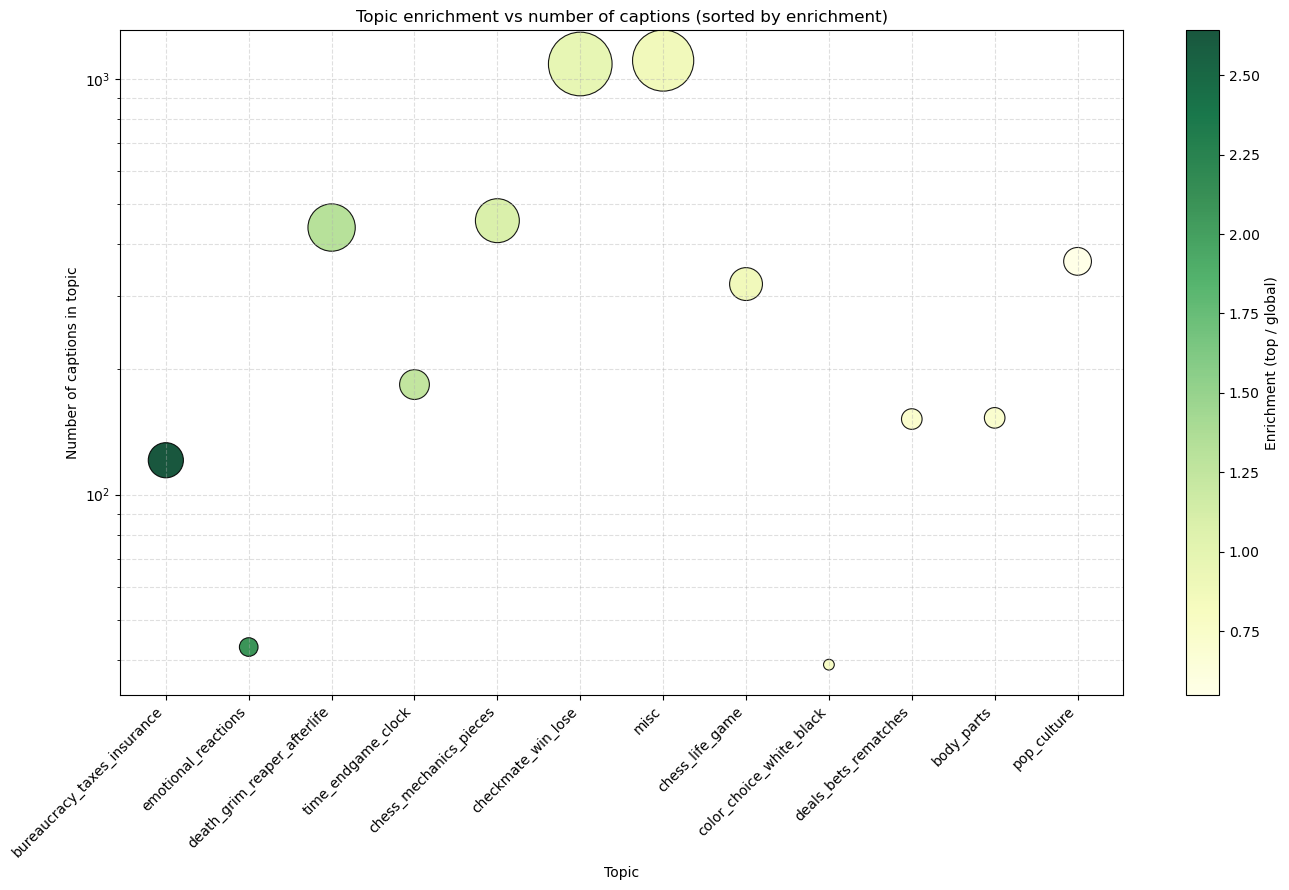

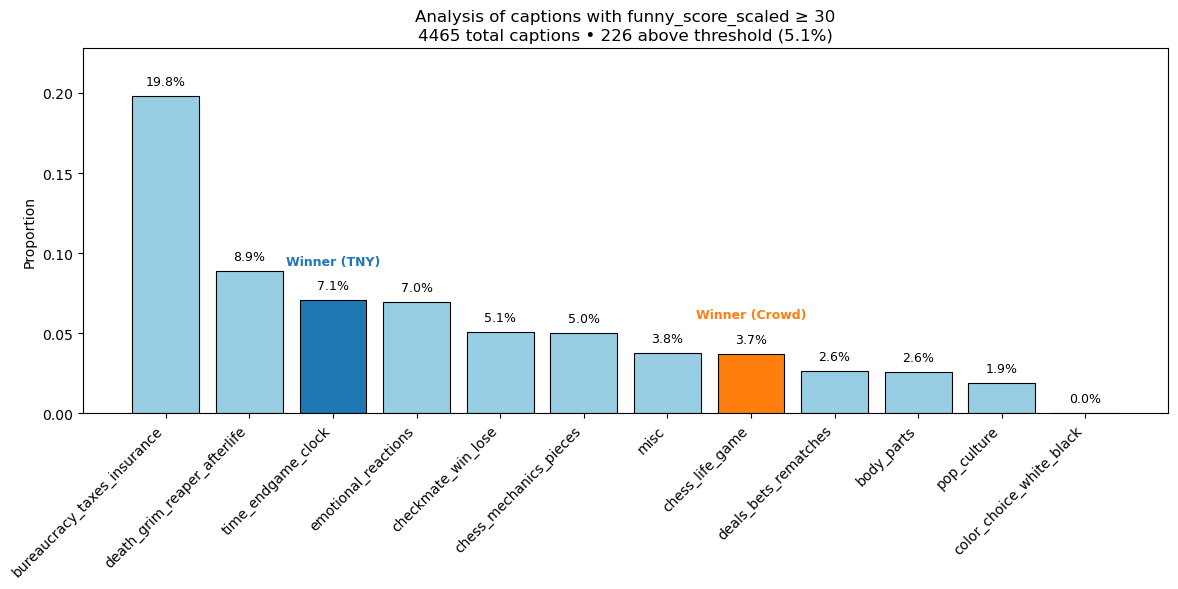

In [9]:
### 1. Calcule un score d’enrichissement pour voir quels topics sont sur-représentés dans le top
df_top, df_mid, enrichment = clusterer.stratify_percentiles_and_compare(data_m, top_pct=10, middle_pct=(40,60))
#clusterer.plot_bubble_enrichment(enrichment, save=os.path.join("_Other", "cycy_analysis", "saved_plots", f"enrichment_{contest_idx}.html"))
clusterer.plot_bubble_enrichment_plt(enrichment)



### 2. Barplot with the proportion of captions above a certain score (the average score) for all topics
#clusterer.plot_proportion_above_threshold(data_m, threshold=30, save=os.path.join("_Other", "cycy_analysis", "saved_plots", f"prop_above_thresh_{contest_idx}.html"))

# Colorer le graph ci-dessus en fonction de quel topic contient les captions gagnante selon TNY ou selon le rank du crowd sourcing
#clusterer.plot_proportion_above_threshold_with_winners(data_m, topic_crowd, topic_tny, threshold=30, save=os.path.join("_Other", "cycy_analysis", "saved_plots", f"prop_above_thresh_with_winners_{contest_idx}.html"))
clusterer.plot_proportion_above_threshold_with_winners_plt(data_m, topic_crowd, topic_tny, threshold=30)

*Discussion Method 1*:

This scatterplot directly answers the question: “Which topics are over-represented among the very best captions?”

The vertical axis represents the enrichment score: the ratio between the presence of a topic in the top 10% of captions and its presence in the middle range (40–60%). A score > 1 indicates qualitative overperformance.

Results :

- The theme of bureaucracy/taxes/insurance is about 2.5 times more prevalent in the top 10%, making it by far the topic that “produces excellence” the most.
- Emotional reactions show about 2 times enrichment; these are often powerful captions that surely have more potential to create humor.
- The majority of other topics have an enrichment score close to 1: they are neither over- nor under-represented in the top 10%.

This graph specifically addresses the bias identified earlier: it ignores the mass of mediocre captions and focuses solely on a topic's ability to generate hits. Hits win less often than some others, but when they do, they win big. This is a key distinction for understanding competitive humor.

===========================


*Discussion Method 2:*

Here, we change perspective again. We no longer look at the top 10%, but at the probability that a caption will exceed the average score. The threshold corresponds to: 30/100 for funny_score_scaled for this cartoon from May 23, 2022.

Results:
- Bureaucracy / Taxes / Insurance : This topic stands out, with the highest proportion of “successful” captions, reaching around 20% above the success threshold (30/100). It is not only capable of producing a few exceptional captions, but also a relatively high number of consistently funny ones.
- Death / Grim Reaper / Afterlife : This topic also shows a solid success rate, which makes sense given the cartoon itself. The theme fits very well with the image, making it easier for captions to connect with the audience. About 8% of captions exceed the success threshold.
- Pop culture: In this contest, pop culture performs quite poorly overall. While some references work very well (like the “death and taxes” idea), many others do not. References to topics such as the Supreme Court, COVID, or specific movies lead to a lot of low-scoring captions.
- The rest of the topics are below 7% of caption score above 30/100.

This graph helps clarify the previous results: a topic can produce a few very strong captions (high enrichment score), but still be risky overall.



##### **e. Conclusion**
Yes, some topics are statistically better at producing excellent captions. But winning is less about choosing the “best” topic, and the best sentence length - and more about finding a singular, surprising idea inside it.
“High-performing” topics increase the chances of producing a good caption, but they do not guarantee success in the The New Yorker Caption Contest.


## 2.2. Axis 2 - How professions are laughed about

The methodology for this part of the data story starts by loading and preparing the data again. The official dataset is loaded in the same way as in the previous sections. Captions are lightly cleaned using simplified preprocessing. Contractions are expanded, punctuation is removed, and stopwords as well as single character words are removed. Lemmatisation is not applied, as it can negatively affect occupation terms. Typo correction is also not applied, as it is too time consuming.

After preprocessing, a TF IDF matrix is created. This matrix is not used extensively for modelling, but it is used to identify where occupation terms occur in the captions and how often they appear. A t-test based on the TF-IDF data showed that captions with occupations tend to be less funny on average (t-stat of -6.0).

Once these components are ready, the ``OccupationAnalysis`` object is created. This object encapsulates all methods used for the occupation based analysis. Its initial construction is time consuming (takes at least 5 hours!) because it builds two core dataframes that store occupation level and category level information. These dataframes are required for all subsequent analyses. Once they have been created and saved, the object can be reinitialised much faster by providing the file paths to these precomputed dataframes.

The occupaional dataframe has statistics about each occupation: where they occur, their mean, median funniness, all their funniness scores, frequency, number of ocntest they occur in. The database with categories is similarly built (see doc).

In [4]:
#loading packages specific to this analysis.
import importlib
import src.data.tokenise as tokenise
importlib.reload(tokenise)
from src.utils.tf_idf_matrix import extract_documents
from src.data.tokenise import load_data, preprocess_text_list, apply_preprocessing, save_data
from src.models.occupation_analysis import OccupationAnalysis
from src.utils.occupation_analysis import load_occupation_mapping
import time
from src.models.gender_analysis import GenderAnalysis
from src.scripts.axis2 import *

#loading occupation list
occupation_list = pd.read_csv(OCCUPATIONS_CSV_PATH)["Synonyms"].tolist()

#flatten
flat_occupation_list = [syn.lower() for sublist in occupation_list for syn in ast.literal_eval(sublist)]
occupation_list = flat_occupation_list

# loading lightly cleaned data.
data_A_occ, data_C_occ, dataA_startID, dataA_endID, dataC_lastGoodID = load_data(STORED_DATAPREPNOUNS_PKL_PATH)

# Loading TF-IDF matrix and metadata
tfidf_matrix = load_npz(TFIDF_MATRIX_NPZ_PATH)
metadata = np.load(TF_IDF_MATRIX_METADATA_NPZ_PATH)
occupation_indices = metadata["occupation_indices"]
occupation_counts = metadata["occupation_counts"]

# Loading the TF-IDF vectoriser to get feature names
vectoriser = joblib.load(TFIDF_MATRIX_JOBLIB_PATH)
feature_names = vectoriser.get_feature_names_out()

#initialize OccupationAnalysis object
documents, scores, contest_id = extract_documents(data_A_occ, 'cleaned_caption', 'funny_score_scaled')

occupation_analysis = OccupationAnalysis(
    tf_idf_matrix=tfidf_matrix,
    feature_names=feature_names,
    term_indices=occupation_indices,
    term_counts=occupation_counts,
    scores=scores,
    occupations_mapping= load_occupation_mapping(OCCUPATIONS_CSV_PATH),
    documents=documents,
    contest_ids=contest_id,
    occupation_df_path=OCCUPATIONS_ANALYSIS_PKL_PATH,
    category_caption_df_path=OCCUPATIONS_CATEGORY_ANALYSIS_PKL_PATH,
    force_rebuild=False
)

Loading cached occupation dataframe...
Loading cached category-caption dataframe...


The code below hows how the tf-idf matrix is created. It i commented out to avoid re-running accidentally. In this block, we also extract all documents and scores from the dataset ino a long series. The vectoriser gets by itself the topics an crearet the tf-idf. This matrix can be used to count the weighted frequency of occupations and also save the inices where they are in the tf-idf (i.e. column and row numbers)

In [5]:
#The code here is commented out to avoid re-running the TF-IDF matrix creation every time.

'''
#Preprocessing to keep only nouns in captions
data_A, data_C, dataA_startID, dataA_endID, dataC_lastGoodID = load_data(STORED_DATAPREP_PKL_PATH) # loads the general data
print(f"Starting simplified preprocessing...")
data_A_occ, data_C_occ = apply_preprocessing(data_A, data_C, min_len=1)
print("Saving simplified preprocessed data...")
save_data(data_A_occ, data_C_occ, dataA_startID, dataA_endID, dataC_lastGoodID, STORED_DATAPREPNOUNS_PKL_PATH)

#load preprocessed data
data_A_occ, data_C_occ, dataA_startID, dataA_endID, dataC_lastGoodID = load_data(STORED_DATAPREPNOUNS_PKL_PATH)

#creating the tf-idf matrix
documents, scores, _ = extract_documents(data_A_occ, 'cleaned_caption' , "funny_score_scaled") # extracts the cleaned captions from all dataframes in data_A_occ
tf_idf_matrix, vectoriser = create_tf_idf_matrix(documents, print_time = True)
feature_names = vectoriser.get_feature_names_out()
scores = np.array(scores)

#extract occupation term indices and counts (takes around 6 hours, depending on the number of occupation terms)
occupation_counts, occupation_indices = extract_terms_counts(tf_idf_matrix, feature_names, occupation_list)

#save
save_npz(TFIDF_MATRIX_NPZ_PATH, tf_idf_matrix)

np.savez(TF_IDF_MATRIX_METADATA_NPZ_PATH,occupation_indices=occupation_indices, occupation_counts=occupation_counts)
joblib.dump(vectoriser, TFIDF_MATRIX_JOBLIB_PATH)'''

'\n#Preprocessing to keep only nouns in captions\ndata_A, data_C, dataA_startID, dataA_endID, dataC_lastGoodID = load_data(STORED_DATAPREP_PKL_PATH) # loads the general data\nprint(f"Starting simplified preprocessing...")\ndata_A_occ, data_C_occ = apply_preprocessing(data_A, data_C, min_len=1)\nprint("Saving simplified preprocessed data...")\nsave_data(data_A_occ, data_C_occ, dataA_startID, dataA_endID, dataC_lastGoodID, STORED_DATAPREPNOUNS_PKL_PATH)\n\n#load preprocessed data\ndata_A_occ, data_C_occ, dataA_startID, dataA_endID, dataC_lastGoodID = load_data(STORED_DATAPREPNOUNS_PKL_PATH)\n\n#creating the tf-idf matrix\ndocuments, scores, _ = extract_documents(data_A_occ, \'cleaned_caption\' , "funny_score_scaled") # extracts the cleaned captions from all dataframes in data_A_occ\ntf_idf_matrix, vectoriser = create_tf_idf_matrix(documents, print_time = True)\nfeature_names = vectoriser.get_feature_names_out()\nscores = np.array(scores)\n\n#extract occupation term indices and counts (ta

Once this is complete, we have an object that handles all analyses and plots, so only short snippets need to be run. Even the BERTopic analysis should take only a few minutes, because the number of distinct occupation occurrences has been reduced. The long runtime above is mainly due to the very large occupation list I constructed, which contains substantial repetition and includes roles that could be removed. This is a clear area for improving the model.

We can now give a strong overview of how occupations are represented and perceived in the dataset. For exploratory analysis, I propose the following seven plots.

1. Plot the top 20 occupations by the number of captions in which they appear.

2. For the most frequent occupations, plot the number of contests in which they appear to assess whether they are widespread or concentrated in a small subset.

3. Plot the distribution of funniness scores for selected occupations (doctor, lawyer, president, clown, CEO, cop) to check normality and whether the mean or median is the more suitable summary.

4. Plot the occupations with the highest median funniness scores, restricting to occupations above a chosen minimum frequency threshold.

5. Plot the occupations with the lowest average funniness scores, again applying a minimum frequency threshold.

6. Plot funniness by occupation using either mean with standard deviation or box plots to show both central tendency and variability.

Furthermore, we can conduct statistical tests on the identified jobs above, to see if any of those perform better than others. These will provide some fun introductory stats that we can use in the datastory. Finally, use the designed method to compare the average funniness of cpations with or without an occupation. This method also takes around 40 minutes to run (looping through 60k occupations and the 2million captions). It simply creates a dataframe based on the tf-idf matrix, but this is not used later, so the only important outcome here is the t-test (occupations are not funny...).

### 2.2.1 : Where do occupations appear and how frequent are they ?

In [5]:
# preliminary_occupation_df = occupation_analysis.exploratory_occupation_analysis()  # calculate around 40 minutes here...
# display(preliminary_occupation_df)

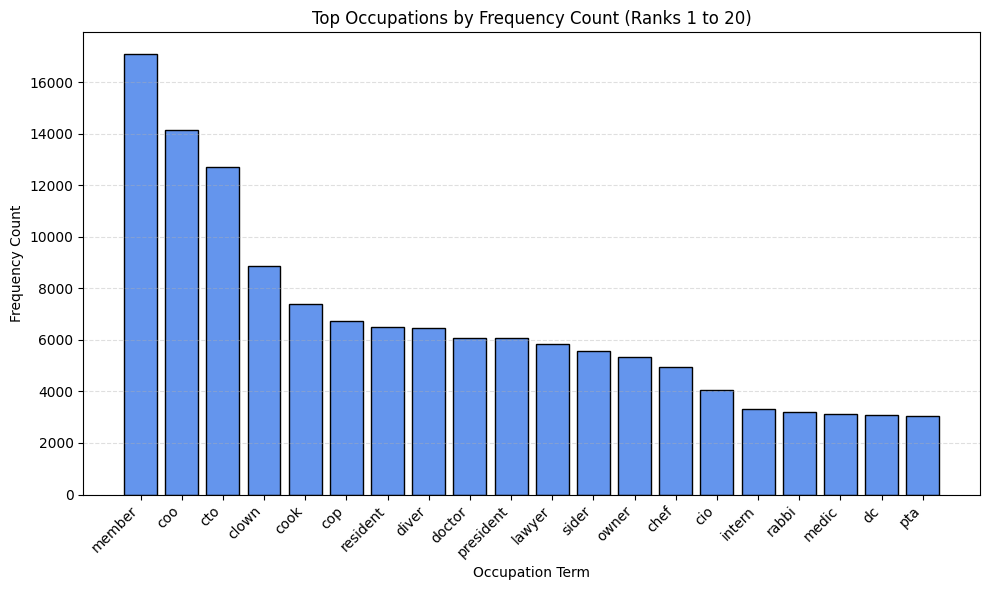

In [6]:
#plot of highest count occupations
occupation_analysis.plot_top_occupations_by_count(start = 0, end = 20, save_path = None, plot_method='plt', color='cornflowerblue')
#filename = "_webappp/assets/graphs/occupation_frequency_plot.html" 
#occupation_analysis.plot_top_occupations_by_count(start = 0, end = 20, save_path = filename, plot_method='plotly', color='blugrn')

In [7]:
occupations_to_delete = ['oral', 'dp', 'racker', 'tier', 'dd', 'holder', 'transit', 'freak', 'maker', 'film', 'starter', 'roller', 'solar', 'mater', 'heater', 'printer', 'pca', 'mannequin', 'bumper', 'opener', 'md', 'boomer', 'packing', 'display', 'typing', 'dinger', 'bitter', 'filing', 'sticker', 'recyling', 'alteration', 'farrier', 'raveler', 'loading', 'cpa', 'dtr', 'rdh', 'copper', 'topper', 'mental health']
occupation_analysis.remove_terms_from_analysis(occupations_to_delete)
occupations_to_delete = ['ta', 'ot', 'od', 'bos', 'rn', 'lin', 'ob', 'pt', 'coo', 'cto', 'member', 'diver', 'sider', 'dc', 'pta', 'ager', 'cio', 'resident', 'import', 'media', 'owner', 'layer', 'roper', 'np', 'icer', 'cook']
occupation_analysis.remove_terms_from_analysis(occupations_to_delete)
occupations_to_delete = ['pallbearer', 'pointer', 'clinical']
occupation_analysis.remove_terms_from_analysis(occupations_to_delete)
occupations_to_delete = ['sewing', 'rrt', 'lather']
occupation_analysis.remove_terms_from_analysis(occupations_to_delete)

We clearly see the apparition of wrong terms that should not exist. These need to be removed manually from the database. I have removed the non-occupation jobs from the OCcupationAnalysis model, but not necessarily from the actual occupational list that was used to construct. The first 300 in the list should be exclusively jobs now.

The plot above shows what term occur most often. The fact that clowns are so popular is probably because it is a synonym for foolish behaviour, so it is not always used as a reference to actual clowns.

In [ ]:
#plotting a dropdown with plotly
# occupation_analysis.plot_occupation_dropdown(page_size = 20, save_path = filename) 
# filename = "_webappp/assets/graphs/occupation_dropdown_plot.html" 

The next idea is to look at the frequency of the top occupations i.e. in how many cartoons  they occur. Use his to dicuss hat they are quite common to occur throughout the contest, not in specific competitions.

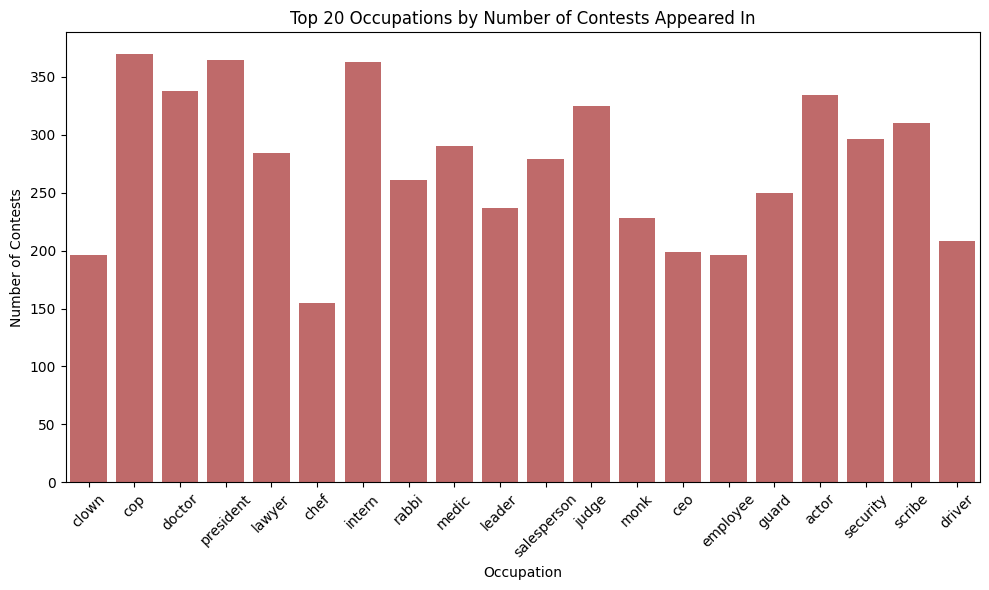

In [8]:
occupation_df = occupation_analysis.get_occupation_dataframe()
category_caption_df = occupation_analysis.get_category_caption_dataframe()

occupation_analysis_df = occupation_df.sort_values(by = 'term_count', ascending = False)
plt.figure(figsize=(10,6))
sns.barplot(data=occupation_analysis_df.head(20), x='term', y='num_contests', color='indianred')
plt.title('Top 20 Occupations by Number of Contests Appeared In')
plt.xlabel('Occupation')
plt.ylabel('Number of Contests')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.2 : Are some categories of occupation funnier than others ?


Before reporting mean or median funniness scores for captions that mention occupations, it is important to look at the shape of the distributions of funniness of captions. Summary statistics can be misleading when the data are skewed, in which case we should look at medians and not means.

Because our goal is to compare how occupations relate to funniness, we begin by looking directly at the full distributions. Visualising density and spread lets us check whether the data are approximately symmetric, or whether they exhibit skewness and long tails. It also helps us identify whether the two groups we compare have similar variance. 


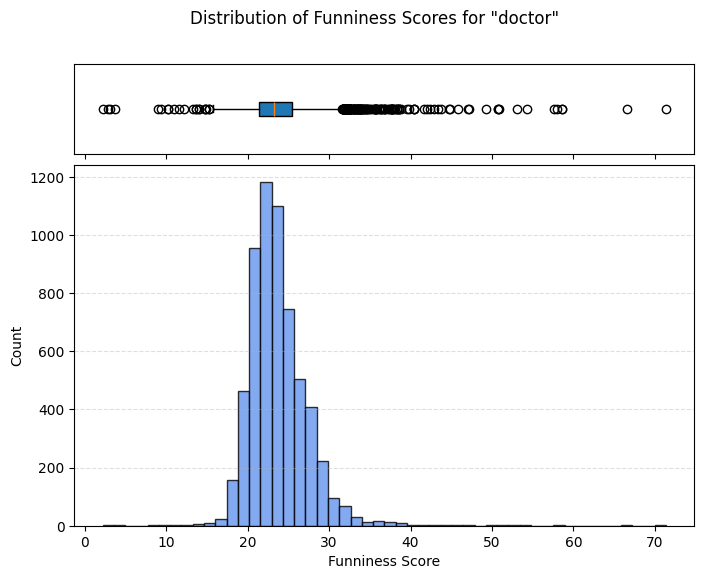

In [9]:

#distribution of funny scores for captions containing a specific occupation
main_occupations = ['doctor', 'lawyer', 'president', 'nurse', 'cop', 'clown', 'ceo', 'intern']
filenames = None  # or provide a path to save the plot]
nbins = 50 # reduce numbers if too many bars
plotting_dfs = []
filename = None
i = 0 # index of the occupation to plot
df_plot = occupation_analysis.plot_occupation_distribution(main_occupations[i], save_path=filename, nbins=nbins, plot_method='plt')

In [ ]:
# #plotting with button to select occupation
# main_occupations = ['doctor', 'lawyer', 'president', 'nurse', 'cop', 'clown', 'ceo', 'intern']
# filenaame = "_webappp/assets/graphs/occupation_distribution_multiple.html"
# nbins = 50
# occupation_analysis.plot_occupation_distribution_multiple(main_occupations, save_path=filenaame, nbins=nbins)

What we see is that some distributions are more skewed than others, but the overall pattern is consistent. Most occupations show a heavier right tail than left tail, meaning there are more high scoring outliers than extremely low scoring ones. The distributions rise sharply on the left side, which suggests that very unfunny captions are relatively rare, while a smaller number of notably funny captions stretch the distribution towards higher scores.

We shoul Use the median value for comparison to account for skewness a bit better.


Now we can look at the top 20 occupations by median funniness, as well as the 20 weakest performers. Two patterns stand out. First, frequency is not the same as performance. With the exception of "rabbi", none of the most frequently mentioned occupations appear among the top median performers. On the other end, "leader" appears among the least funny occupations, suggesting that broad, generic role labels do not reliably translate into strong jokes.

Second, the rankings are compressed. The top and bottom lists sit close together in absolute terms. Only "juror" stands out as a clear over performer, with a median a few points above its neighbours. Otherwise, the top 20 shows only a gentle decline across the axis, and the same gradual pattern appears for the bottom 20.

In fact, the gap between the best and worst median performers is only about five points on a 0 to 100 scale. This suggests that occupations, by themselves, rarely determine whether a caption succeeds. They can colour the setup, a stereotype, or signal a familiar setting, but the difference between occupations is typically a small shift rather than a dramatic jump in funniness.

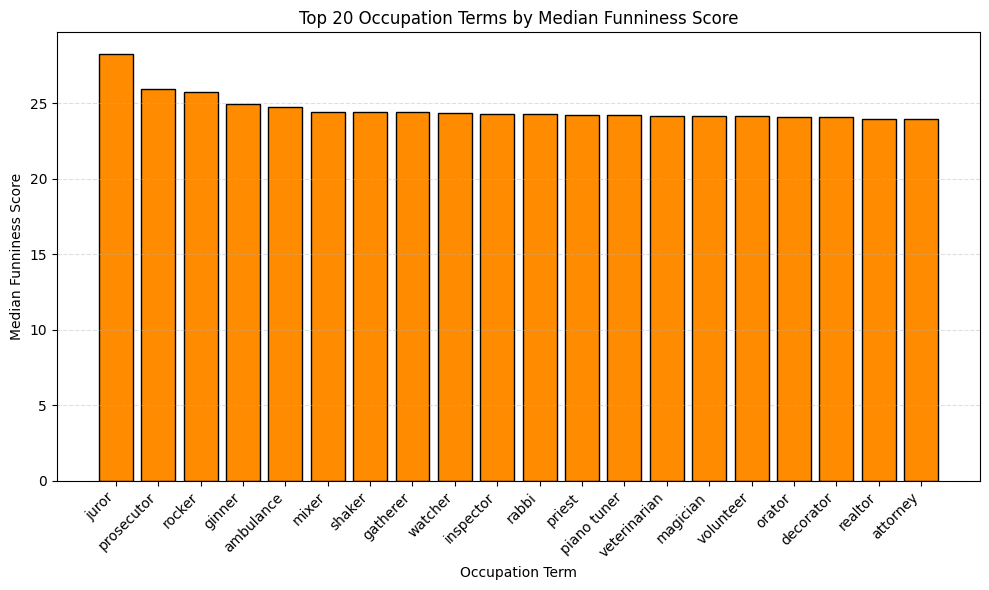

In [10]:
#plot of occupations with highest average funny scores
threshold = 200
#filename = "_webappp/assets/graphs/top_occupations_by_avg_funniness.html"  # or provide a path to save the plot
#occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = filename, measure='avg', threshold = threshold)
#filename = "_webappp/assets/graphs/top_occupations_by_median_funniness.html"  # or provide a path to save the plot
#occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = filename, measure='median', threshold = threshold)

occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = None, measure='median', threshold = threshold, color='darkorange', plot_method='plt')

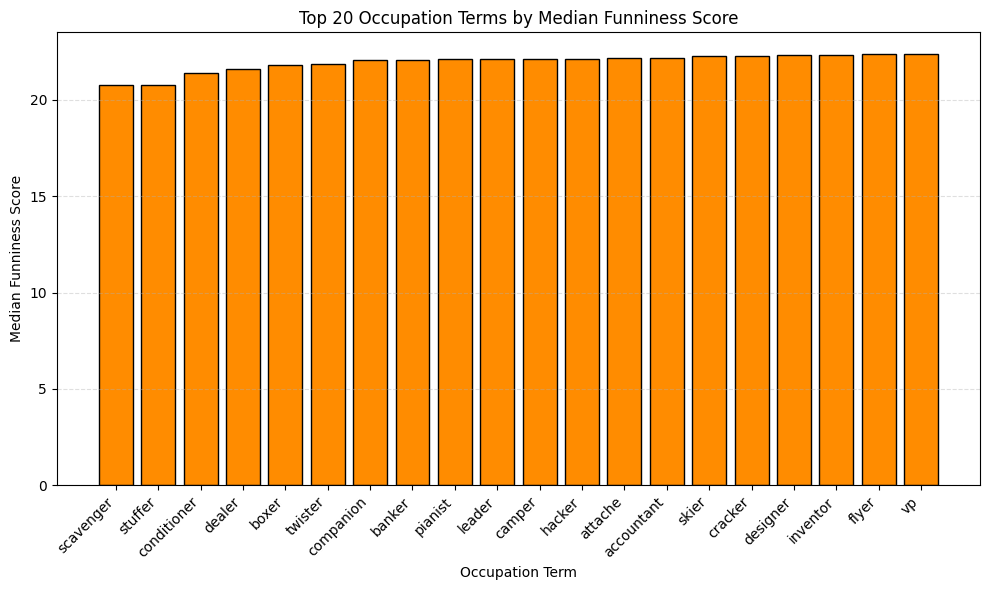

In [11]:
#plotting the lowest average funny scores/median funny scores

#filename = "_webappp/assets/graphs/lowest_occupations_by_avg_funniness.html"  # or provide a path to save the plot
#occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = filename, measure='avg', ascending=True, threshold = 200)
#filename = "_webappp/assets/graphs/lowest_occupations_by_median_funniness.html"  # or provide a path to save the plot
#occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = filename, measure='median', ascending=True, threshold = 200)
#occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = None, measure='avg', ascending=True, threshold = 200, color='cornflowerblue', plot_method='plt')
occupation_analysis.plot_top_occupations_by_funniness(top_n = 20, save_path = None, measure='median', ascending=True, threshold = 200, color='darkorange', plot_method='plt')


box plots are just another helpful way to look at distribution. We see again the previous beahviour: lot of outliers on the funny side, but the median is around 23, and very few low performers. The boxes seem more or less well divided by the median, though there is an elongation above the median compared to below.

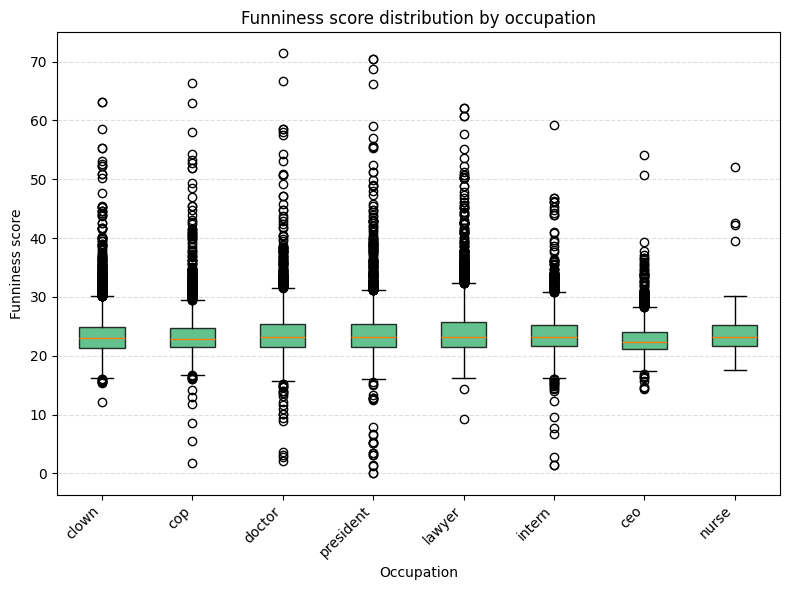

In [12]:
#plotting box plots of multiple occupations
main_occupations = ['doctor', 'lawyer', 'president', 'nurse', 'cop', 'clown', 'ceo', 'intern']
#occupation_analysis.plot_occupation_box_plot(main_occupations, save_path=filename, color='mediumseagreen', )
#filename = "_webappp/assets/graphs/occupation_box_plots.html"  # or provide a path to save the plot
occupation_analysis.plot_occupation_box_plot(main_occupations, save_path=None, color='mediumseagreen', plot_method='plt')


The first step in our comparison is a Kruskal Wallis test. It is like the multi group counterpart to the Mann Whitney U test. Rather than comparing two occupations at a time, it tests whether the groups as a whole are likely to come from the same distribution, or whether at least one group differs.

Formally, the null hypothesis is that all groups share the same distribution of funniness scores, while the alternative is that at least one group is different. This makes the Kruskal Wallis test a useful screening step. If we fail to reject the null, there is little reason to proceed with detailed pairwise testing. If we do reject it, the test does not tell us which occupations differ, only that some difference exists somewhere in the set. In that case, we follow up with other tests.

The results clearly show that there is some difference in distributions.

In [13]:
#comparing a set of occupations' scores
main_occupations = ['doctor', 'lawyer', 'president', 'nurse', 'cop', 'clown', 'ceo', 'intern']
alpha = 0.05
stat, p_values = occupation_analysis.compare_set_of_occupations(main_occupations, interpret=True, alpha = alpha)



Kruskal-Wallis test statistic: 262.1970, p-value: 0.0000
The differences in funniness scores among the occupations are statistically significant (alpha = 0.05).


We can do individual testing here below for each combination if we want to, but the heatmap further down is probably better. In any cae, the testing below is Whitney-Mann U test and a fucntion to get CLiff's delta.

In [158]:
#compare each occupation to 'compare_to' occupation
compare_to = 'doctor'
alternative = 'two-sided'  # 'greater', 'less', 'two-sided'
alpha = 0.05
for occ in main_occupations:
    if occ != compare_to:
        print("-----------------------------")
        print(f"Comparing occupation: {occ} to {compare_to}")
        stat, p_value = occupation_analysis.compare_occupations(occ, compare_to, interpret=True, alpha=alpha, alternative=alternative)
        delta = occupation_analysis.cliffs_delta_occupations(occ, compare_to, interpret=True, alpha=alpha)


-----------------------------
Comparing occupation: lawyer to doctor
Mann-Whitney U test statistic: 18208748.0000, p-value: 0.0067
The difference in funniness scores between 'lawyer' and 'doctor' is statistically significant (alpha = 0.05).
Cliff's Delta: 0.0287 (negligible effect size)
-----------------------------
Comparing occupation: president to doctor
Mann-Whitney U test statistic: 18399007.5000, p-value: 0.8715
The difference in funniness scores between 'president' and 'doctor' is not statistically significant (alpha = 0.05).
Cliff's Delta: 0.0017 (negligible effect size)
-----------------------------
Comparing occupation: nurse to doctor
Mann-Whitney U test statistic: 199841.5000, p-value: 0.6807
The difference in funniness scores between 'nurse' and 'doctor' is not statistically significant (alpha = 0.05).
Cliff's Delta: 0.0299 (negligible effect size)
-----------------------------
Comparing occupation: cop to doctor
Mann-Whitney U test statistic: 19439618.5000, p-value: 0.000

Below we implement a helper method that returns two summary matrices for our pairwise comparisons: a p value matrix from the Mann Whitney U tests and a Cliff’s delta matrix for effect sizes. This helps with visualisation.

When we interpret these heatmaps, it helps to keep the same lesson in mind as in the occupation level analysis. The p value matrix tells us where differences are detectable in the dataset, but it does not tell us whether those differences are large. With many pairwise tests and large sample sizes, it is common to see a sea of small p values, even when the underlying distributions overlap substantially. For this reason, the Cliff’s delta matrix is essential. It tells us the direction and magnitude of the differences, and it lets us separate comparisons that are statistically significant but practically minor from comparisons that show a clearer separation.

The p value heatmap looks dramatic, with significant differences for most pairs, but the delta heatmap showed that effect sizes were generally small and clustered near zero. The same interpretation strategy applies here.

The problem here is tha there are statistically speaking very little as conclusions we can draw because all cliffs deltas are under the negligible threshold. So, why the p-values offer some interpretations, the CLiffs deltas dampen any conclusions we could make...

In [159]:
#pairwise comparison of all occupations
main_occupations = ['doctor', 'lawyer', 'president', 'nurse', 'cop', 'clown', 'ceo', 'intern']
alpha = 0.05
pval_matrix, delta_matrix = occupation_analysis.pairwise_occupation_testing(main_occupations, alpha=alpha)


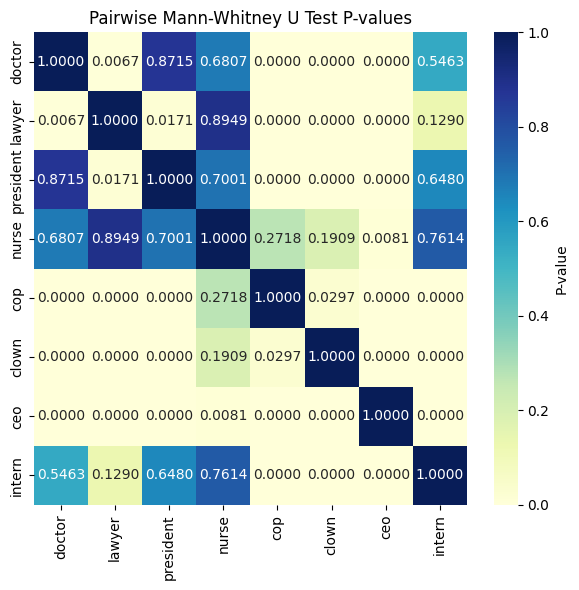

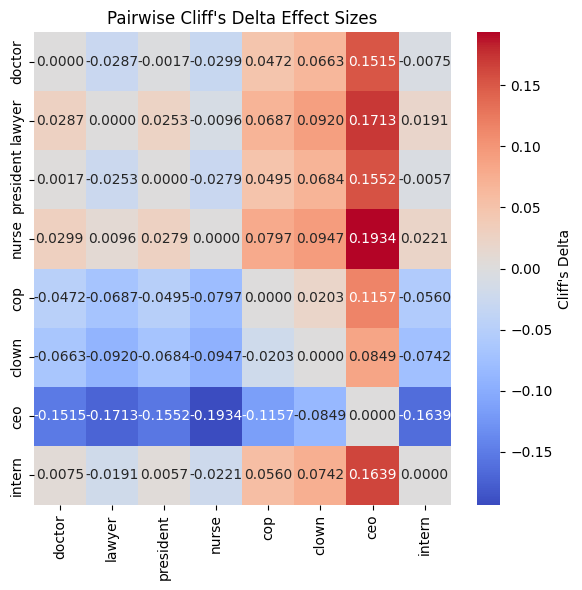

In [160]:
#display heatmaps
plt.figure(figsize=(6,6))
sns.heatmap(pval_matrix, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'P-value'})
plt.title('Pairwise Mann-Whitney U Test P-values')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
sns.heatmap(delta_matrix, annot=True, fmt=".4f", cmap="coolwarm", center=0, cbar_kws={'label': "Cliff's Delta"})
plt.title("Pairwise Cliff's Delta Effect Sizes")
plt.tight_layout()
plt.show()


Because we cannot rely on individual job titles alone, as the tests above suggest, it makes sense to group related occupations together. This is not only a statistical decision, but also a natural interpretative one. When people joke about work, they often reach for broad labels, or they use different titles to point to the same familiar idea. In everyday humour, "attorney" and "lawyer" are rarely treated as meaningfully different characters.

In practice, grouping every occupation into a single clean, general term is difficult and would introduce a great deal of ambiguity. Instead, we take a more robust approach and create broader occupational categories. These categories do not claim that all jobs within them are identical. Rather, they reflect the assumption that occupations within the same general field tend to attract similar stereotypes, settings, and comedic frames. This lets us reduce noise, increase sample sizes, and analyse occupational humour at a level that better matches how readers commonly think about professions.

#### 2.2.2 Are some categories of occupation funnier than others ?

The next step in the analysis is to group occupations into broader categories.
These groupings were defined using ChatGPT and are intended to capture meaningful thematic similarities between occupations. All group labels are stored as attributes of the model and are used consistently throughout the analysis.
The identified occupation groups are:

1. Arts and Entertainment

2. Business, Management and Finance

3. Law, Government and Politics

4. Healthcare and Medicine

5. Education and Academia

6. Science and Engineering

7. Trades, Crafts and Manufacturing

8. Service Industry and Hospitality

9. Transportation and Logistics

10. Agriculture, Animals and Outdoors

11. Public Safety, Military and Security

12. Sports and Fitness

13. Media and Communications

14. Domestic and Personal Care

The occupations contained in each group, exactly as defined here, can be printed by calling the ``print_group("group_name")`` method of the analysis.

All other occupations that appear in the captions but do not clearly belong to one of these categories are grouped under Miscellaneous. These occupations are excluded from the core analyses that follow, in order to focus on interpretable and sufficiently represented categories.

Once this categorisation is done, one can examine the box plots of the different occupation groups. These visualisations summarise the distribution of funniness scores within each category, including the mean, median, standard deviation, and the presence of outliers. This allows us to assess whether humour associated with certain occupational domains... We will be able to see what kind of descriptors we should use: means or medians.

Furthermore, we can now conduct some statistical tests to compare if one group is funnier than the other. We can conduct the following tests:
1. Start with Kruskal Wallis test to evaluate score distributions across categories (for reason like before)
2. For targeted hypotheses, we can use Mann Whitney U tests (To produce heatmaps)
3. We also need to report on the size of groups to assess the effect sizes between groups. (Cliff's delta)

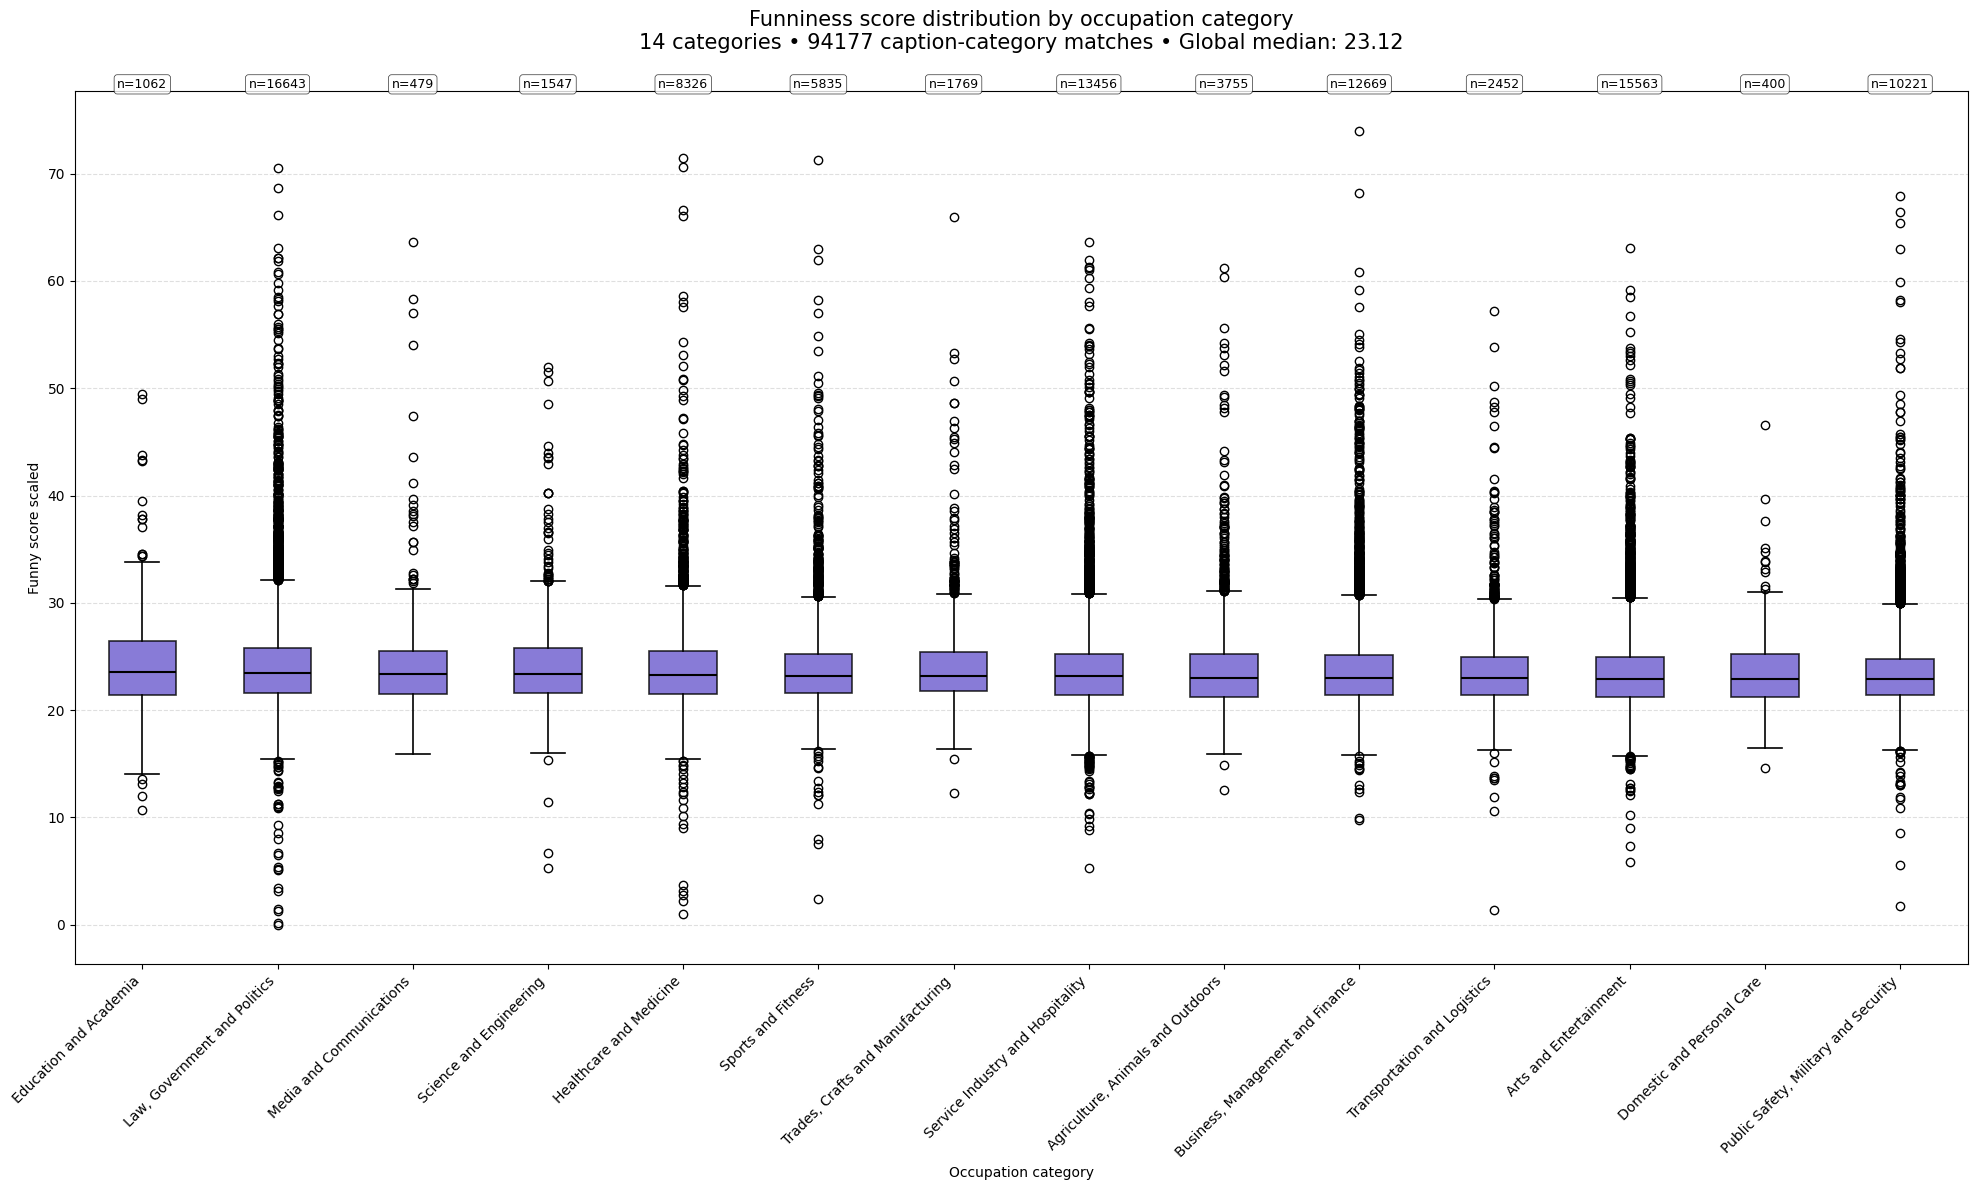

In [14]:
#filename = "_webappp/assets/graphs/occupation_category_boxplot.html"  # or provide a path to save the plot
#occupation_analysis.plot_category_boxplot(save_path=filename, order_by='median', color='slateblue')
occupation_analysis.plot_category_boxplot(save_path=None, order_by='median', color='slateblue', plot_method='plt')

The box plots for the categories show the same results as already we saw for the inividual occupations. We have a median score around 23 for each group, with Education and Academia being the highest. The boxes for "Service, Industry And Hospitality", "Agriculture, Animals and Outoors" seem quite evenly split by the median, while most of the others have an elongated right side. We also see many more outliers on the higher funny scores, just as we have for the individual occupations. This again suggest that humour with the occupational categories is more dense on low scores with the occasionally well performing joke. Again, the relatively dense structure around the median score means that occupation does not make the caption funny, they are more influenced by the context and the image.

This means we still need to look statistical testing as we talked about before. These are all done below and we again found that the Kruskal-Wallis test shows difference in distributions. 

In [15]:
#testing krukal wallis
occupation_analysis.kruskal_wallis_test(interpret=True, alpha=0.05)

Kruskal-Wallis test statistic: 438.4176, p-value: 0.0000
The differences in funniness scores across categories are statistically significant (alpha = 0.05).


(np.float64(438.4176334230084), np.float64(1.679979317985797e-85))

In [16]:
#targeted pairwise comparisons between occupations
compare_to = "Law, Government and Politics"
occupations_categories = occupation_analysis.get_occupation_categories()
compare = occupations_categories.keys()

alpha = 0.05
alternative = 'two-sided'  # 'greater', 'less', 'two-sided'
for cat in compare:
    if cat != compare_to and cat != 'Miscellaneous':
        print("-----------------------------")
        print(f"Comparing occupation category: {cat} to {compare_to}")
        stat, p_value = occupation_analysis.targeted_category_test(cat, compare_to, interpret=True, alpha=alpha, alternative=alternative)
        delta = occupation_analysis.cliffs_delta(cat, compare_to, interpret=True, alpha=alpha)

-----------------------------
Comparing occupation category: Arts and Entertainment to Law, Government and Politics
Mann-Whitney U test statistic: 115541903.0000, p-value: 0.0000
The difference in funniness scores between 'Arts and Entertainment' and 'Law, Government and Politics' is statistically significant (alpha = 0.05).
Cliff's Delta: -0.1078 (effect size: negligible)
-----------------------------
Comparing occupation category: Business, Management and Finance to Law, Government and Politics
Mann-Whitney U test statistic: 97175040.5000, p-value: 0.0000
The difference in funniness scores between 'Business, Management and Finance' and 'Law, Government and Politics' is statistically significant (alpha = 0.05).
Cliff's Delta: -0.0783 (effect size: negligible)
-----------------------------
Comparing occupation category: Healthcare and Medicine to Law, Government and Politics
Mann-Whitney U test statistic: 66840802.5000, p-value: 0.0000
The difference in funniness scores between 'Health

With the cross pairwise testing we can again create a heatmap similarly a we have before. The discusion of the values is left to the webpage, but essentially we see a similar pattern as before: there are some categories which come from unique distrivbutions, while others for which we cnanot reject the null hypothesis that they come from the same. Interesting patterns occur, that show that topic like governemnt and education cannot be separated (cannot reject the null hypotheses) which is in some ways evident since the two often intertwine and so the humoour we have with them is also similar

It must be noted at this point that my analysis rests on a hypothesis that the captions talking about one category are generally only talking about that category, and no other occupation come up (ie. that comments are independent). This of course could be violated but I have decided that this should not occur very often so that the results of the test shouldnt change too much. For the actual heatmaps, please refer to the website, as they have disappeared during a merge and could not be added back in time.

Cliff delta is also similar to what we have seen before. The size of the deltas is very cloe to zero implying that we have negligible sizes and differences in distributions. This makes sense for the measures where we could not reject the null hypothesis, however, for places where the p-value is vary small, we only observe a minor increase in delta value with either negligible or small effect size. This is once again an artefact of the limited resources and shows that in the end, the distributions of any of the groups do not differ so much.

### 2.2.3 : Do we appreciate work of other people ? Temporal, topic analysis, sentiment Analysis

We can also look at some temporal evolution of the categories, or even individual occupations. However, I can already say the conclusion is that there is no significant spike in certain job mentions due to real world events: the spikes are governed by the image itself. Furthermore, since my method of looking at occupations is quite primitive (need exact mention of the occupation) it is hard to find the subtext in a caption. Due to this, we cannot conclude that people joke about occupations based on world events. This study is not conducted further, but one can plot all the temporal data they wish by changing the keywords in the functions below (see later). This analysis was fully conducted in another notebook (see ``_Other/andras_analysis/axis2_complete.ipynb``) where we identified with the help of ChatGPT different groups that we could track that might highlight a certain trend. For example, I will plot what we found for ppolitical terms that could have been influenced by the US elections of 2016 and 2020. Other groups like environmental  debates, health terms, law enforcement terms etc were also checked with no positive results...

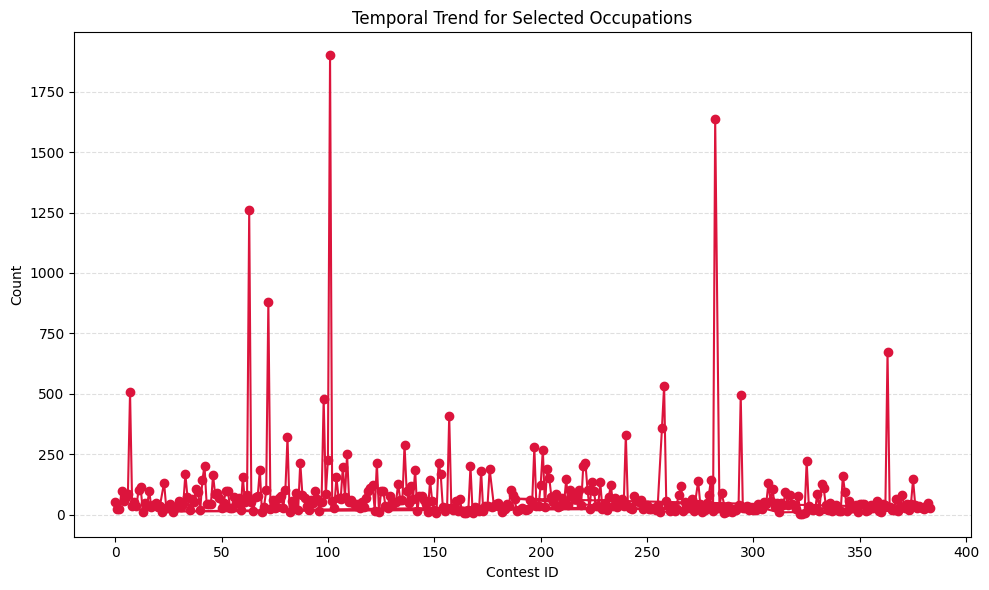

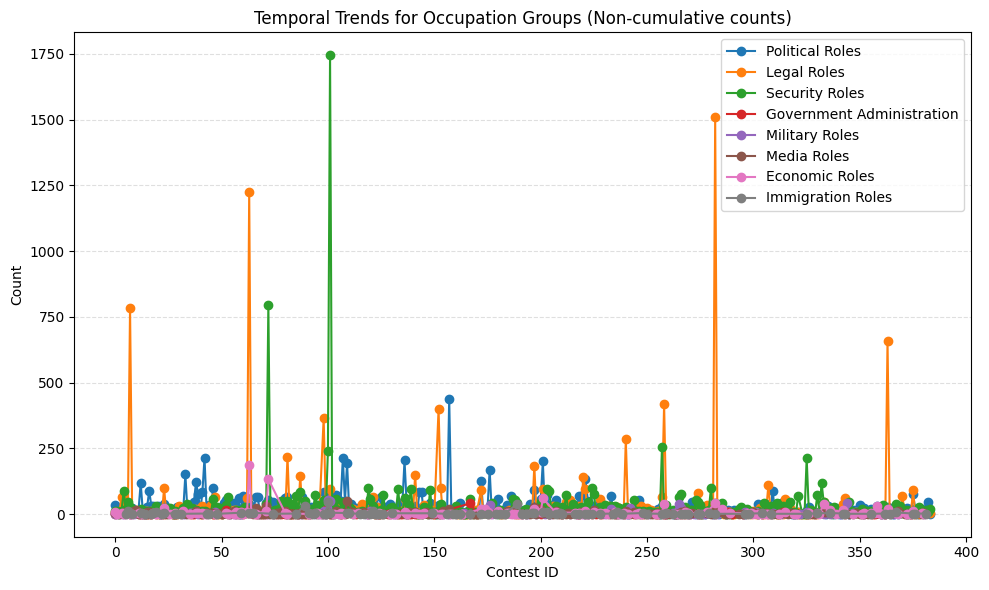

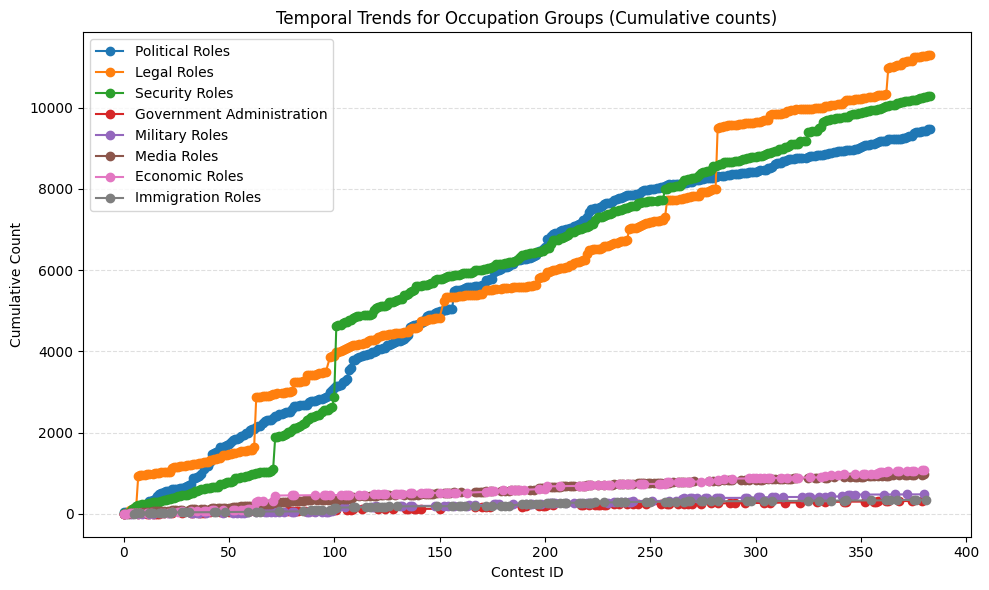

In [17]:
political_roles = ["president", "vice president", "governor", "mayor","senator", "congressman", "congressperson","representative", "state representative","ambassador", "diplomat", "commissioner","legislator", "politician", "attorney general","secretary", "official", "city official","precinct captain"]

legal_roles = [
    "judge", "justice", "lawyer", "attorney", "district attorney",
    "trial lawyer", "corporate lawyer", "public defender",
    "prosecutor", "patent attorney", "criminal lawyer",
    "legal counsel", "legal advisor", "paralegal",
    "litigator", "litigation attorney", "court officer",
    "court stenographer", "juror"
]

security_roles = [
    "cop", "police officer", "policeman", "policewoman",
    "police chief", "police detective", "security",
    "security guard", "security officer", "prison guard",
    "marshal", "sheriff", "deputy", "state trooper",
    "border patrol", "parole officer", "fbi agent",
    "cia agent", "inspector", "investigator",
    "detective", "homicide detective", "transit police",
    "constable"
]

government_admin = [
    "advisor", "adviser", "administrator", "bureau chief",
    "civil servant", "public administrator", "city planner",
    "official greeter", "ombudsman", "commissioner"
]

military_roles = [
    "soldier", "officer", "sergeant", "lieutenant",
    "colonel", "commander", "general", "security consultant",
    "intelligence agent", "naval", "seaman", "able seaman",
    "marine", "fire captain", "fire chief"
]

media_roles = [
    "journalist", "reporter", "columnist", "news writer",
    "news anchor", "commentator", "press secretary",
    "publicist", "editor", "publisher", "analyst",
    "strategist", "fact checker", "lobbyist",
    "speech writer"
]

economic_roles = [
    "banker", "investment banker", "financial advisor",
    "financial analyst", "economist", "auditor",
    "treasurer", "accountant", "actuary"
]

immigration_roles = [
    "border patrol", "immigration officer", "customs officer",
    "inspector", "patrol agent"
]

#simplified core political occupations
core_political_occupations = [
    "president", "senator", "congressman", "mayor", "governor",
    "judge", "lawyer", "attorney",
    "cop", "police officer", "security", "guard",
    "journalist", "reporter",
    "agent", "investigator", "detective",
    "soldier", "officer",
    "lobbyist", "press secretary", "publicist"
]

#Track the different groups and their count in the data as a fucntion of which id they come from
occupation_group_counts = {
    "Political Roles": political_roles,
    "Legal Roles": legal_roles,
    "Security Roles": security_roles,
    "Government Administration": government_admin,
    "Military Roles": military_roles,
    "Media Roles": media_roles,
    "Economic Roles": economic_roles,
    "Immigration Roles": immigration_roles
}

#tracks a single list of occupations
#filename = "_webappp/assets/graphs/core_political_occupations_temporal_trends.html"
#occupation_analysis.plot_temporal_trends(occupations=core_political_occupations, cumulative = False, save_path=filename, color = 'crimson')
occupation_analysis.plot_temporal_trends(occupations=core_political_occupations, cumulative = False, save_path=None, color = 'crimson', plot_method='plt')
#tracks groups of occupations
# filename = "_webappp/assets/graphs/occupation_groups_temporal_trends.html"
# occupation_analysis.plot_group_temporal_trends(group_dict=occupation_group_counts, cumulative = False, save_path=filename)
# filename = "_webappp/assets/graphs/occupation_groups_cumulative_temporal_trends.html"
# occupation_analysis.plot_group_temporal_trends(group_dict=occupation_group_counts, cumulative = True, save_path=filename)
occupation_analysis.plot_group_temporal_trends(group_dict=occupation_group_counts, cumulative = False, save_path=None, plot_method='plt')
occupation_analysis.plot_group_temporal_trends(group_dict=occupation_group_counts, cumulative = True, save_path=None, plot_method='plt')

As mentioned before, temporal analysis was not included in the webpage because we could not find any temporal reasons on why certain terms were popular or not. In general, it is the image that influences the occupations present, more than any political influence

Of course, this does not imply that there is no temporal trend to detect, but that we cannot do it through occupations only. Maybe if we had more data it could work.

#### Topic Analysis

Next we turn to topic detection with Bertopic. Since we only have a limited number of captions with mentions of occupations, it is easier to look at groups of occupations. Hence, with the predefined groups we have above, we can remove the occupation from the caption itself, and see what the remaining caption has as identifiable topics. Once topics are detected, we use ChatGPT to create grouping of the many different topics that are found (aggragat topics). This is becaue BERTopic finds quite specific topics, which are similar to others or just too general.

In doing so, we also limit all of the grpahs that we produce for the website to aggragate topics with more than 200 occurences in captions, to remove any noise. With all these specifications, we are able to construct relatively good groupings that can be easily interpreted. Note that some of the categories we have defined do not have enough mentions or categories to form any coherent groups from. These can be dropped in the analysis.

In [14]:
occupations_categories = occupation_analysis.get_occupation_categories()
occupations_categories_names = list(occupations_categories.keys())

In [180]:
#Avoid re-running topic modelling every time
# topic_models = {}
# outputs = {}
# topic_infos = {}
# save = True
# #topic modelling for each occupation category (some are redundant as they are too small)
# for occ_cat in occupations_categories_names:
#     topic_model, output = occupation_analysis.topic_model_category(occ_cat, min_topics=20, ngram_size = (1,2), min_tokens = 2, model_name = 'all-MiniLM-L6-v2')
#     topic_models[occ_cat] = topic_model
#     outputs[occ_cat] = output
#     #save topic models to a csv
#     topic_info = topic_model.get_topic_info()
#     topic_info['Representative Documents'] = topic_info['Topic'].apply(lambda t: topic_model.get_representative_docs(t))
#     topic_infos[occ_cat] = topic_info
#     if save:
#         topic_info.to_csv(f"data/topic_model_{occ_cat.replace(' ', '_')}.csv", index=False)
#         output.to_csv(f"data/topic_model_output_{occ_cat.replace(' ', '_')}.csv", index=False) # currently saves to current working directory... save to data instead
#     print(f"Completed topic modelling for occupation category: {occ_cat}")


load if exist, if not, use the cell above.

In [15]:
#load topics models from csv
topic_infos = {}
for occ_cat in occupations_categories_names:
    topic_infos[occ_cat] = pd.read_csv(f"data/topic_model_{occ_cat.replace(' ', '_')}.csv")
    

The table with data is below. For analysis, THe images produced for the webite can be ued.

In [ ]:
#print the topics for a specific occupation category
categories = list(occupation_analysis.get_occupation_categories().keys())
occupation_category = categories[1]  # change index to select different category
#use loaded data
df = topic_infos[occupation_category]
df = df[df['Topic'] != -1]  # Exclude outlier topic
df = df.sort_values(by='Count', ascending=False)
display(df.head(5))

,Topic,Count,Name,Representation,Representative_Docs,Representative Documents
1,0,913,0_owner_previous_owners_grew,"['owner', 'previous', 'owners', 'grew', 'origi...","['one owner', 'previous owners eleven', 'one p...","['one owner', 'previous owners eleven', 'one p..."
2,1,269,1_dog_pet_dogs_pets,"['dog', 'pet', 'dogs', 'pets', 'animal', 'dogh...","['pet owners think next', 'like pet owners', '...","['pet owners think next', 'like pet owners', '..."
3,2,265,2_chef_food_menu_kitchen,"['chef', 'food', 'menu', 'kitchen', 'lunch', '...","['told chef thought said execute chef', 'asked...","['told chef thought said execute chef', 'asked..."
4,3,209,3_cretaceous_period_jurassic_late,"['cretaceous', 'period', 'jurassic', 'late', '...","['thought cretaceous period', 'well always cre...","['thought cretaceous period', 'well always cre..."
5,4,194,4_pull_pulls_legend_gets,"['pull', 'pulls', 'legend', 'gets', 'able', 'r...","['pull become', 'pull get', 'pull get']","['pull become', 'pull get', 'pull get']"


For each of the categories, we can aggragate the topics that are found to form more general groupings. This has to be done manually, and is done by using CHatGPT. After this is done, we can make a nice visualisation with a table and hoverable data, by seting a certain threshold on the number of occurences needed for a topic.

In [18]:
#Looks complicated because I wanted to fix something but I cannot.
from src.utils.occupation_topics import TOPIC_GROUPINGS, LABEL_GROUPINGS
topic_names = TOPIC_GROUPINGS.keys()
topic_labels = LABEL_GROUPINGS.keys()
#aggragate mapping
aggregated_info_dfs = []
for occ_cat, topic, label in zip(occupations_categories_names, topic_names, topic_labels):
    topic_info = topic_infos[occ_cat]

    #contain converion dicts for each topic and label for better readability
    grouping_dict = TOPIC_GROUPINGS.get(topic, {})
    label_dict = LABEL_GROUPINGS.get(label, {})

    aggregated_info_dfs.append(occupation_analysis.map_aggragate_topics_external(topic_info, grouping_dict, label_dict))

#plot each
# for occ_cat, aggregated_topic_df, human_readable_groupings in zip(occupations_categories_names, aggregated_info_dfs, topic_names):
#     filename = f"_webappp/assets/graphs/aggregated_topics_{occ_cat.replace(' ', '_')}.html"
#     occupation_analysis.plot_aggregated_topics_treemap_external(aggregated_topic_df,  min_mentions = 200, save_path=filename, color="Pastel", title =f"Aggregated Topics for {occ_cat}")

i = 0  #index of occupation category to display

#occupation_analysis.plot_aggregated_topics_treemap_external(aggregated_info_dfs[i],  min_mentions = 200, save_path=None, color="Pastel", title =f"Aggregated Topics for {occupations_categories_names[i]}")
print(f"Table of aggregated topics for occupation category: {occupations_categories_names[i]}")
display(aggregated_info_dfs[i].sort_values(by='total_count', ascending=False))

Table of aggregated topics for occupation category: Arts and Entertainment


,aggregated_topic,total_count,topics,n_topics,topic_labels
1,"Comedy, Clowns & Absurdism",1159,"[3_clowns_feel_like_inside, 11_car_cars_fit_cl...",14,"[3_clowns_feel_like_inside, 11_car_cars_fit_cl..."
11,"Technology, Props & Technical Metaphors",1146,"[2_models_newer_older_mileage, 8_car_cars_desi...",13,"[2_models_newer_older_mileage, 8_car_cars_desi..."
2,Creative Work & Gig Economy,1051,[1_chiropractor_chiropractors_appointment_reco...,11,[1_chiropractor_chiropractors_appointment_reco...
5,"Film, Theatre & Performance",849,"[0_film_filming_films_filmed, 27_actors_method...",7,"[0_film_filming_films_filmed, 27_actors_method..."
6,"Institutions, Authority & Satire",706,"[4_cop_bad_good_routine, 26_president_washingt...",8,"[4_cop_bad_good_routine, 26_president_washingt..."
13,"Writing, Literature & Cartoons",677,"[6_poetry_poetic_poets_justice, 14_block_write...",9,"[6_poetry_poetic_poets_justice, 14_block_write..."
4,Everyday Life & Observational Humor,659,"[31_starving_eat_diet_hamburger, 33_cheesecake...",13,"[31_starving_eat_diet_hamburger, 33_cheesecake..."
7,"Language, Wordplay & Cognition",603,"[10_factor_wow_warp_factors, 12_monkeys_typewr...",9,"[10_factor_wow_warp_factors, 12_monkeys_typewr..."
12,"Visual Arts, Design & Fashion",490,"[7_painted_paint_painting_picasso, 30_suit_out...",7,"[7_painted_paint_painting_picasso, 30_suit_out..."
10,"Place, Culture & Setting",434,"[29_bar_walks_priest_walk, 32_adjacent_adjoini...",9,"[29_bar_walks_priest_walk, 32_adjacent_adjoini..."


#### Sentiment Analysis

Finally, we can conduct a sentiment analysis on what the sentiment towards occupations is. Once again, we have to look at sentiment towards the five largest groups so that we have enough atistical footing and samples to work with. We first plot the compound entiment found with VADER. It is normalised, and we can see positive and negative distributions.

Finally, We can conduct statistical testing to see if there are statistically significant differences between two groups. For this, we need to conduct a Kruskal Wallis test first to see if there is ANY with a statistically significant difference. Then we can conduct pairwise comparisons with a whitnet-Mann U test. This is used because we do not have normal distribution of sentiment. Finally, it is important to also look at Cliffs Delta: depending on its magnitude, we cna see how often a sentiment of one group exceeds that of the other. If the magnitude is small, there is basiucally no difference between the two, meaning that even if we had a positive Whitney Mann test, the results are negligible: we do not have enough data to really make a conclusion on the sentimental differences between two groups.

In [16]:
category_names_examine = ["Arts and Entertainment","Business, Management and Finance","Law, Government and Politics","Healthcare and Medicine","Service Industry and Hospitality","Public Safety, Military and Security"]

#this gets the whole sentiment analysis dataframe for each category, with Vader sentiment scores
sentiment_dfs = []
for cat in category_names_examine:
    print(f"Computing sentiment analysis for category: {cat}")
    sentiment_df = occupation_analysis.compute_sentiment_for_category(cat)
    sentiment_dfs.append(sentiment_df)


Computing sentiment analysis for category: Arts and Entertainment
Computing sentiment analysis for category: Business, Management and Finance
Computing sentiment analysis for category: Law, Government and Politics
Computing sentiment analysis for category: Healthcare and Medicine
Computing sentiment analysis for category: Service Industry and Hospitality
Computing sentiment analysis for category: Public Safety, Military and Security


This plot of the densities shows us that the majority of captions with categories is neutral: this is expected because in general when occupations occur in a text, it is not about pointing it in a negative or positive light, but use absurdity and metaphors. This is in some ways too hard to detect the setniemtn, and it is also quite subjective in a way. We see a larger shift towards the positive sentiment than the negative, with positive sentiment also reaching hihger values than the negative. This means that when sentiment does come into play, the cpations turn more aggressively positive than negative. We must ak if this is by sentiment of caption writers, or by the editors' filtering of caption.

For any other occupational conclusions, refer to the website.

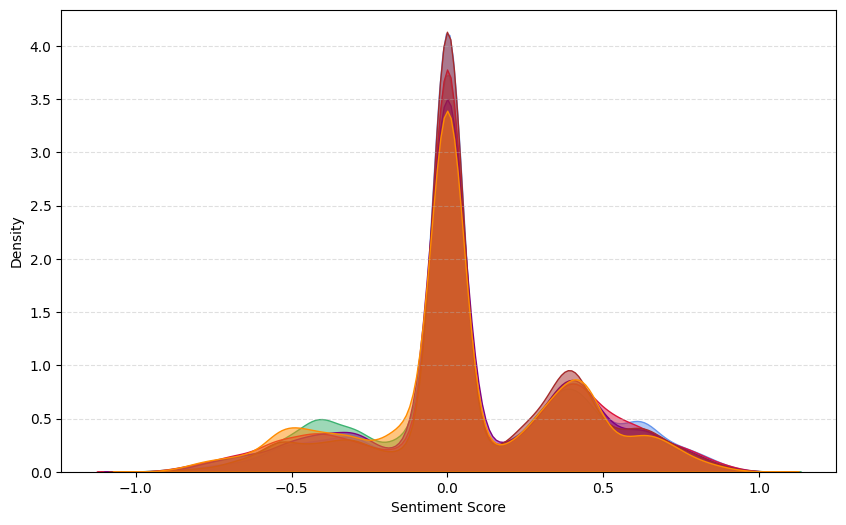

In [17]:
#plots for sentiment analysis
colors = ['mediumseagreen', 'cornflowerblue', 'crimson', 'purple', 'brown', 'darkorange']
#occupation_analysis.plot_sentiment_distribution_external(sentiment_dfs, colors = colors, save_path="_webappp/assets/graphs/sentiment_distribution_occupation_categories.html", plot_method='plotly')
occupation_analysis.plot_sentiment_distribution_external(sentiment_dfs, colors = colors, plot_method='plt')

The summary table below is instructive in showing us statitic about the distributions. Key points to talk about is higher poitive average, but median of zero. Large standard deviaion, and polarity imbalance. The polarity imbalance measures the shift of sentiment is more towards positive or negative, while the posiive and negative percentages (actually fractions) show the fraction of psoitive and negative scores in the captions.

In [190]:
#summary of sentiment analysis for each category
type_of_sentiment = 'compound'
level_of_sentiment = 0.05  # threshold to classify as positive/negative
summaries = {}
for cat, sentiment_df in zip(category_names_examine, sentiment_dfs):
    summary = occupation_analysis.sentiment_summary_by_category(sentiment_df, type_of_sentiment=type_of_sentiment, level=level_of_sentiment)
    summaries[cat] = summary # a dict of dicts
#merge summaries into a single dataframe for easier display
summary_df = pd.DataFrame(summaries).T
display(summary_df.reset_index().rename(columns={"index": "Occupation Category"}).drop(columns="category"))


,Occupation Category,num_sentences,avg_sentiment,median_sentiment,std_sentiment,pct_positive,pct_negative,pct_neutral,polarity_imbalance
0,Arts and Entertainment,15660,0.053247,0.0,0.332061,0.325479,0.235888,0.438633,0.089591
1,"Business, Management and Finance",12721,0.09743,0.0,0.317269,0.351859,0.161701,0.48644,0.190158
2,"Law, Government and Politics",16707,0.077949,0.0,0.338742,0.355001,0.198959,0.446041,0.156042
3,Healthcare and Medicine,8349,0.07694,0.0,0.326821,0.349144,0.197628,0.453228,0.151515
4,Service Industry and Hospitality,13505,0.09202,0.0,0.313933,0.360163,0.16468,0.475157,0.195483
5,"Public Safety, Military and Security",10276,0.052072,0.0,0.333473,0.329895,0.240658,0.429447,0.089237


Kruskal-Wallis shows there is at least one category with a significantly different distribution than the other.

In [192]:
#kruskal wallis test across all categories
alpha = 0.05
type_of_sentiment = 'compound'
stats, p_values = occupation_analysis.sentiment_kruskal_wallis_test_external(sentiment_dfs, interpret=True, alpha=0.05, type_of_sentiment=type_of_sentiment)

Kruskal-Wallis test statistic: 238.7152, p-value: 0.0000
The differences in sentiment scores across categories are statistically significant (alpha = 0.05).


Heatmap below, done by conducting pairwise testing for ach category's sentiment score.  similar conclusions as for previous images. See the website for discussion of values. main problems to do with cliff values, while p-values can be interpreted nicely.

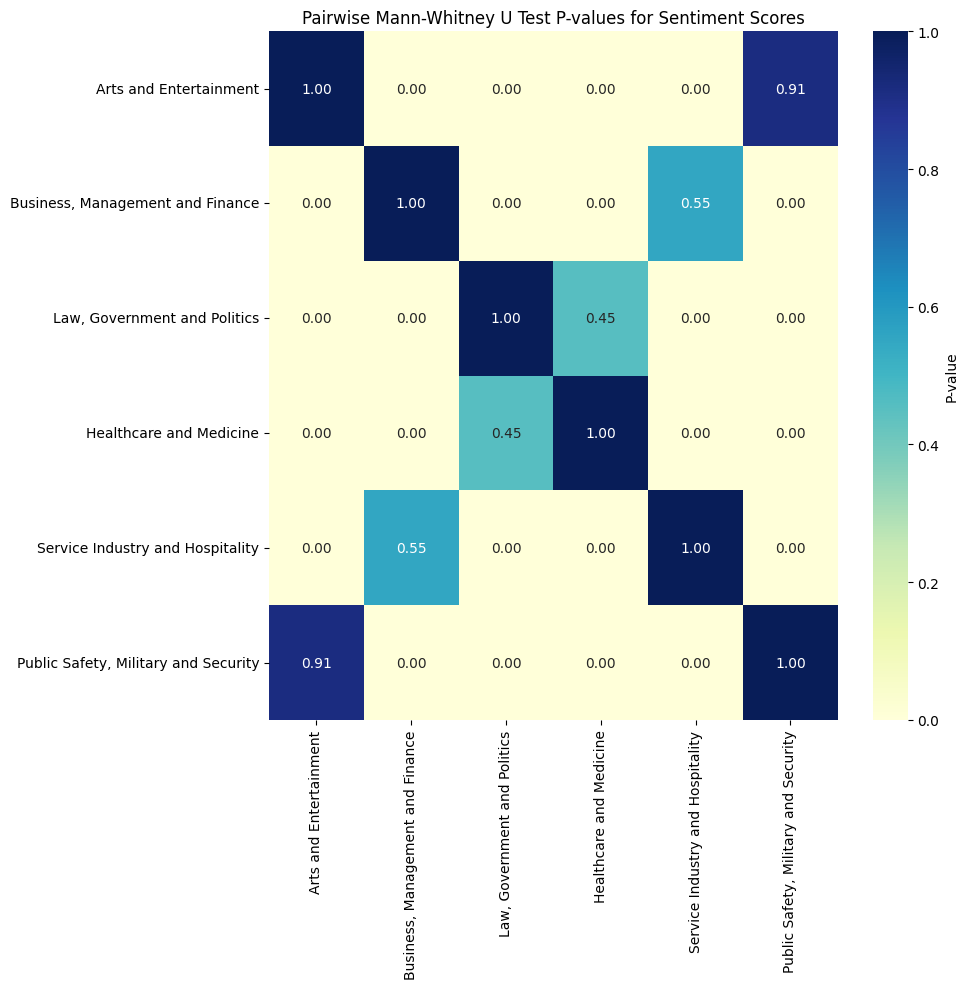

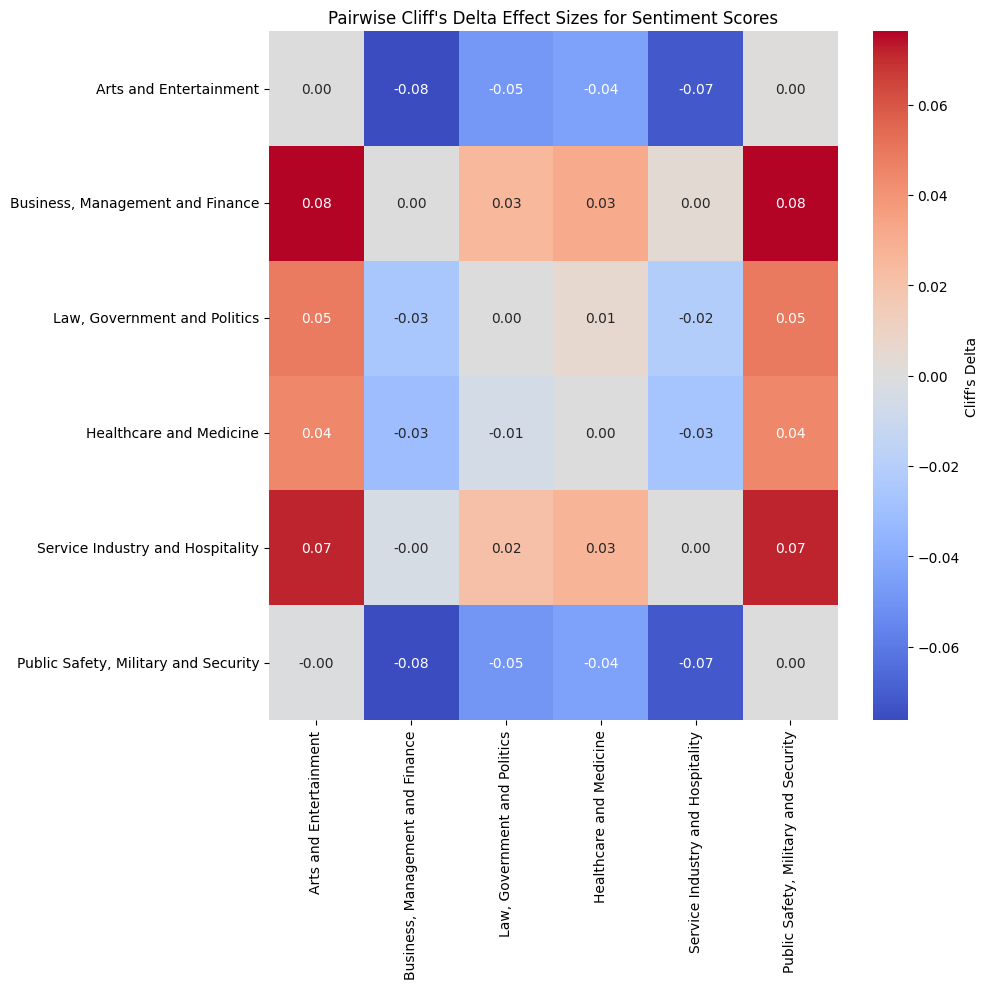

In [ ]:
def pairwise_sentiment_testing_external(sentiment_dfs, category_names, alpha=0.05, type_of_sentiment='compound'):
    n = len(sentiment_dfs)
    pval_matrix = pd.DataFrame(np.ones((n, n)), index=category_names, columns=category_names)
    delta_matrix = pd.DataFrame(np.zeros((n, n)), index=category_names, columns=category_names)

    for i in range(n):
        for j in range(i + 1, n):
            stat, p_value = occupation_analysis.sentiment_mann_whitney_external(
                sentiment_dfs[i],
                sentiment_dfs[j],
                interpret=False,
                alpha=alpha,
                alternative='two-sided',
                type_of_sentiment=type_of_sentiment
            )
            delta = occupation_analysis.sentiment_cliffs_delta_external(
                sentiment_dfs[i],
                sentiment_dfs[j],
                interpret=False,
                type_of_sentiment=type_of_sentiment
            )

            pval_matrix.iloc[i, j] = p_value
            pval_matrix.iloc[j, i] = p_value
            delta_matrix.iloc[i, j] = delta
            delta_matrix.iloc[j, i] = -delta  # Cliff's delta is directional

    return pval_matrix, delta_matrix

#heatmaps for sentiment pairwise comparisons
pval_matrix, delta_matrix = pairwise_sentiment_testing_external(sentiment_dfs, category_names_examine, alpha=0.05, type_of_sentiment='compound')
plt.figure(figsize=(10,10))
sns.heatmap(pval_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'P-value'})
plt.title('Pairwise Mann-Whitney U Test P-values for Sentiment Scores')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
sns.heatmap(delta_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': "Cliff's Delta"})
plt.title("Pairwise Cliff's Delta Effect Sizes for Sentiment Scores")
plt.tight_layout()
plt.show()



It must be kept in mind for all statistical tests that I did not separate captions if they had multiple occupations so technically the independence assumption made when conducting statistical testing is false. There can be captions with multiple occupations. I have worked under the assumption that two occupations occuring in a single caption are quite unlikely, and therefore the discussion remains pertinent. It must be noted that for a better analysis, we would have to only test captions which only have a single occupation. 


If the reader is interested in more graphs and details, they can consult _Other/andras_analysis/axis2_complete.ipynb. It is wher the bulk of the work was done.

## 2.3. Axis 3 - Gender Roles and stereotypes

In this part, we mainly load already existing plots. If the specifics and details of how they were computed interest you, you can consult the file *gender_roles.ipynb* in "src/scripts". It contains all the details and code.

As a reminder here are the two research questions:

1) How are men and women depicted in New Yorker cartoons and captions, and do these depictions reflect traditional gender roles or stereotypes?

2) How does audience response (e.g., votes or winning captions) relate to gendered content—do captions about one gender receive more positive attention ?

### Structure

Here is a quick summary of my structure and methods to answer these questions.

0. Detect gender:

Detect gendered references in captions/descriptions and assign a gender to each of them (male, female, both, neutral). 

1. Look at the general distributions:

Found the overall presence of gender in image descritpions and captions by doing a barplot.

2. Men/Women depictions in the captions:

    a. Find the top words associated with each gender (verbs and adjectives). 

    b. Find topic related to man and woman with BERTopic.

3. Test if writing captions about one gender is funnier

    a. Ploted the distrubution of funny score (the one we created) for both genders, and tested wether there was a significant difference or not with Mann-Whitney and Cliff's delta. 

    b. Did the same for top/worst 5% of captions.

### 2.3.1. Detect gender

The dictionaries were constructed based on Danielle Sucher's "Jailbreak the Patriarchy" 
(https://github.com/DanielleSucher/Jailbreak-the-Patriarchy). Since we wanted a more detailled lists, we added some english names, public figures, universal gendered word and contextual gender markers.

Include male and female names: asked to chatGPT to produce me a list (based on Social Security Administration data)

Include public figures: asked chatGPT for 50 male and female celebrities

The dictionnaries can be found in gender_analysis.py

**METHOD**

It is rather simple actually. We iterate through the cartoons descriptions/captions and depending on the presence of gendered word, label the caption as 'male', 'female', 'neutral' and 'both'



### 2.3.2 General Distributions

Using the label captions and image descriptions, we did some barplots do see how gender is present in our dataset.

Here are the resulting plots. These are png, so that they can be seen on github, they are a bit blurry (sorry about that)

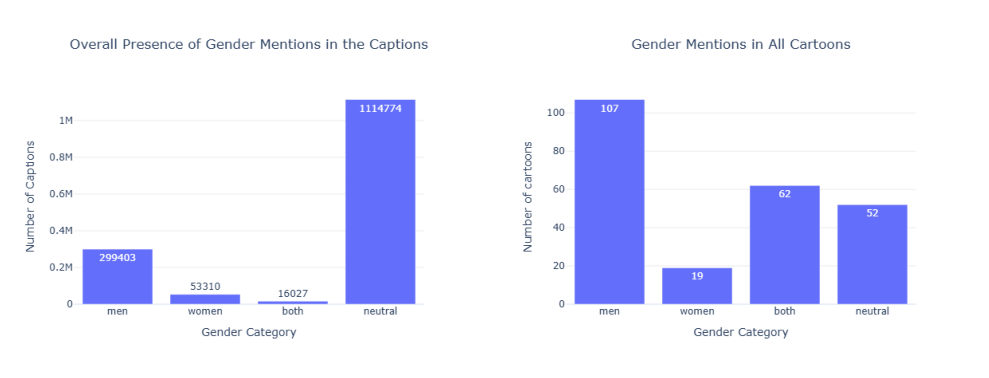

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img1 = mpimg.imread(r"src\data\gender_roles_plots\counts_captions.png")
img2 = mpimg.imread(r"src\data\gender_roles_plots\counts_cartoons.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")

plt.tight_layout()
plt.show()

Almost 50% of the cartoons are related only to men. Also women are present alone only in 8% of the cartoons
and are more often mentioned alongside men. And, as expected, this imbalance is translated to the captions,
where men references clearly dominates. 

### 2.3.3. Gender depiction

Now we want to investigate how are men and women are portrayed once they appear.

#### Top words associated with each gender

**METHOD**

- Tokenize and clean text: Break sentences into words, removing proper nouns, stop words, and the indicator words themselves.

- Count word frequencies by category: Compute how often each word appears in sentences labeled with each category.

- Normalize frequencies: Adjust word counts by the total number of words in each category to make comparisons fair.

$S_{w}^{\text{male}} = \dfrac{\tfrac{c_{w,m}}{N_m}}{\tfrac{c_{w,m}}{N_m} + \tfrac{c_{w,f}}{N_f}}$

Where:  
- $S_{w}^{\text{male}}$ — normalized "male share" score for word $w$; the proportion of the word's usage associated with male-subject sentences.  
- $c_{w,m}$ — count of occurrences of word $w$ in male-subject sentences.  
- $c_{w,f}$ — count of occurrences of word $w$  in female-subject sentences.  
- $N_m$ — total number of words (tokens) across all male-subject sentences.  
- $N_f$ — total number of words (tokens) across all female-subject sentences.  


- Display the results with a wordcloud.

This method is heavily based on the work of Neal Caren (University of North Carolina)

https://nealcaren.github.io/text-as-data/html/times_gender.html

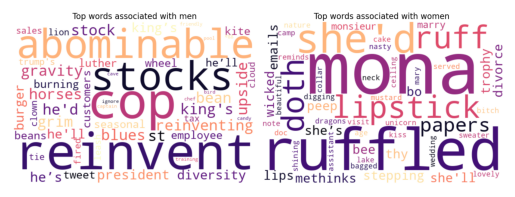

In [ ]:
img = mpimg.imread(r"src\data\gender_roles_plots\wordcloud_gender.png")

plt.imshow(img)
plt.axis("off")
plt.show()

For men, the most prominent words relate to power, finance, and institutional roles: stocks, reinvention, president, employee, customer. Men are frequently positioned within professional, economic, or public spheres, often as actors who control resources, make decisions, or represent authority. Even when humor is involved, it tends to draw on structures of work, money, and leadership.

For women, the dominant words shift toward appearance, relational roles, and domestic contexts: mom, ruffled, lipstick, marry, divorce, lips. Women are more often described through physical traits, clothing, or their roles in relationships, rather than occupations or abstract institutions. Humor here relies more heavily on embodiment and social expectations tied to femininity.

Overall, these word clouds suggest that gendered humor in the New Yorker captions still reflects traditional divisions: men are associated with status, work, and public life, while women are framed through appearance, family, and relational identity. Even without explicit stereotypes, language choices subtly reinforce unequal narrative roles.

#### Topic Modelling

**METHOD**

1) Run BERTopic for each gender. (Since my computer is weak and that I have over 300k captions gendered as male, I had to run BERTopic four separate times.)
2) Aggregate the topic from BERTopic to comprehensive ones. The dictionnaries of this are stored in src\models\gender_analysis.py.
3) Handle the unbalance: Since we have an umbalance in the number of captions for each gender. I decided to use the top themes that cover 60% of captions.
4) Find the top words associated with each aggregated theme
5) Interactive plot for each gender, for each topic representative words are plotted.

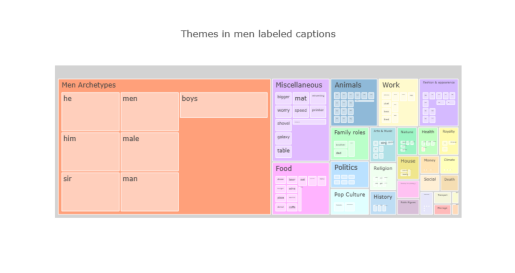

In [ ]:
img = mpimg.imread(r"src\data\gender_roles_plots\topic_men.png")

plt.imshow(img)
plt.axis("off")
plt.show()

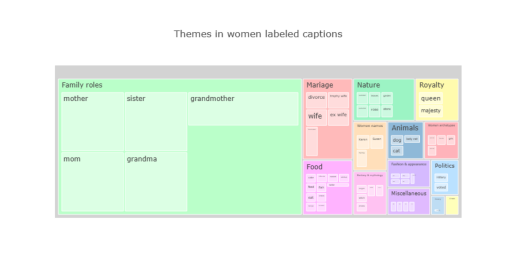

In [ ]:
img = mpimg.imread(r"src\data\gender_roles_plots\topic_women.png")

plt.imshow(img)
plt.axis("off")
plt.show()

The analysis of New Yorker captions reveals a stark gendered difference in humor. Women are often depicted as archetypes—mothers, brides, witches—emphasizing their roles and cultural expectations, with humor arising from what kind of woman they are rather than what they do. Men, in contrast, appear more in situational contexts—workplaces, friendships, absurd events—where humor comes from what happens to them, not their identity. This pattern shows that gender shapes not just who appears in captions, but how jokes are constructed: women as symbols, men as default actors.

### 2.3.4. Gender funniness

To assess whether audience response differs depending on the gender referenced in captions, we followed the steps below:

(This analysis focuses on captions labeled exclusively as men or women.)

**METHOD**

0. Audience response metric: Audience response was measured using the funny score, derived from caption contest votes. Scores were scaled to allow comparison across contests and years.

1. Exploratory analysis

We first visualized:

The evolution of average funny scores over time for men- and women-labeled captions.

The overall distribution of funny scores by gender.

2. Statistical testing (entire dataset)

To formally test differences in audience response, we compared men- and women-labeled captions using:

    a. Mann–Whitney U test to assess whether score distributions differ.

    b. Cliff’s delta to quantify the magnitude of any difference, independently of sample size.

These methods were chosen because:

    a. The distributions are non-normal.

    b. The dataset is strongly imbalanced (many more men-labeled captions).

3. Extreme-caption analysis

To investigate whether gender differences emerge at the extremes, we repeated the analysis on:

    a. The top 5% highest-scoring captions.

    b. The bottom 5% lowest-scoring captions.

For each subset, we again applied:

    a. Mann–Whitney U tests.

    b. Cliff’s delta effect sizes.

#### Whole dataset

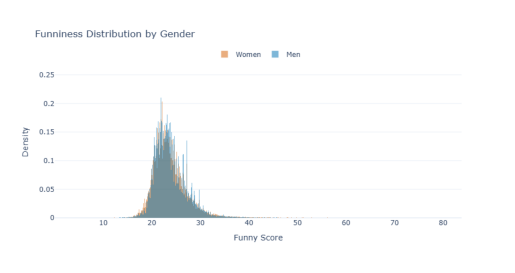

In [ ]:
# still sorry about the blur, they are beautiful on the website :)
img = mpimg.imread(r"src\data\gender_roles_plots\funniness_distrib_by_gender.png")

plt.imshow(img)
plt.axis("off")
plt.show()

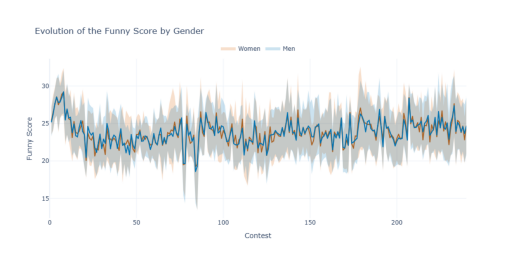

In [ ]:
img = mpimg.imread(r"src\data\gender_roles_plots\evolution_funny_score.png")

plt.imshow(img)
plt.axis("off")
plt.show()

Surprisingly, the curves are almost identical.Both over time and across the full distribution, men- and women-labeled captions appear to receive very similar audience scores.

But visual similarity does not necessarily mean statistical equality. We use the Mann–Whitney U test and Cliff’s delta.

We test the following hypothesis:

H₀: There is no difference in funny score distributions between men- and women-labeled captions. 

From our test we got those results: 

Here is what got from it:
- Mann–Whitney U test: p-value ≈ 3.2 × 10⁻²⁶ → statistically significant
- Cliff’s delta: δ ≈ –0.029 → negligible effect size

This means that in practice, there is no meaningfull preferences of captions about one gender.

Let's move to the top and worst 5% captions.

#### Top/Worst 5% captions

The idea here is to compare if there is a difference in score when it's really funny and when it's not at all. This allows us to study extreme audience reactions rather than average behavior.

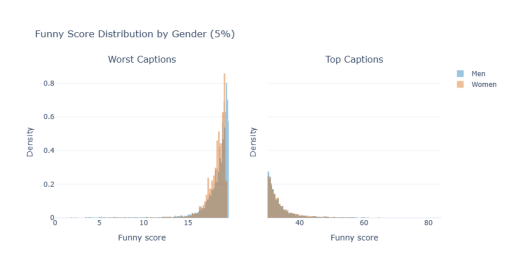

In [ ]:
img = mpimg.imread(r"src\data\gender_roles_plots\funny_score_distrib_5.png")

plt.imshow(img)
plt.axis("off")
plt.show()

Even among the funniest and least funny captions, the distributions remain similar. 

Still, we test this hypothesis formally, by applying the same tests as before.

- We tested two hypotheses separately:
1. Whether the best captions differ by gender
2. Whether the worst captions differ by gender

**Worst 5%**
- p-value: 4.4 × 10⁻⁶⁶ → statistically significant
- Cliff’s delta: –0.207 → small effect

This means that among the worst-performing captions, women-labeled captions tend to score
slightly lower than the men labeled ones. The difference is statistically clear, but the effect
remains small. Not the dramatic result we were expecting...
        
**Top 5%**
- p-value: 0.094 → not statistically significant
- Cliff’s delta: 0.020 → negligible effect

Among the best-performing captions, there is no statistically significant difference.

### What did we learn of the gender representation ?

Despite the clear difference in representation, audience response stays remarkably
gender-neutral. This sets up a compelling tension for the data story:
while stereotypes and archetypes persist in content, they do not translate into clear 
rewards from the crowd.

# A big (thank you)² for this lecture !

# What is the answer to ADA, the universe and everything ?

In [9]:
import random

answer = None
number_of_tries = 0
while answer != 42:
    # Generate one random number
    answer = random.randint(0, 1_000_000)
    number_of_tries += 1

print("Number of TEEEEEENTATIVES:", number_of_tries, end="\r")
print("\nThe answer to ADA, the universe and everything is:", answer)


Number of TEEEEEENTATIVES: 421531
The answer to ADA, the universe and everything is: 42


# <center>Humor as a Mirror: The New Yorker Captions as Reflections of Society, Politics, and Stereotypes</center>
# <center>THE END</center>

<br/><br/>
<center>
    <img src="data/newyorker_caption_contest_virgin/images/606.jpg" alt="New Yorker Cartoon" style="width:300px; height:auto; border-radius:5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
</center>